In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Gaussian process models for stellar variability

When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

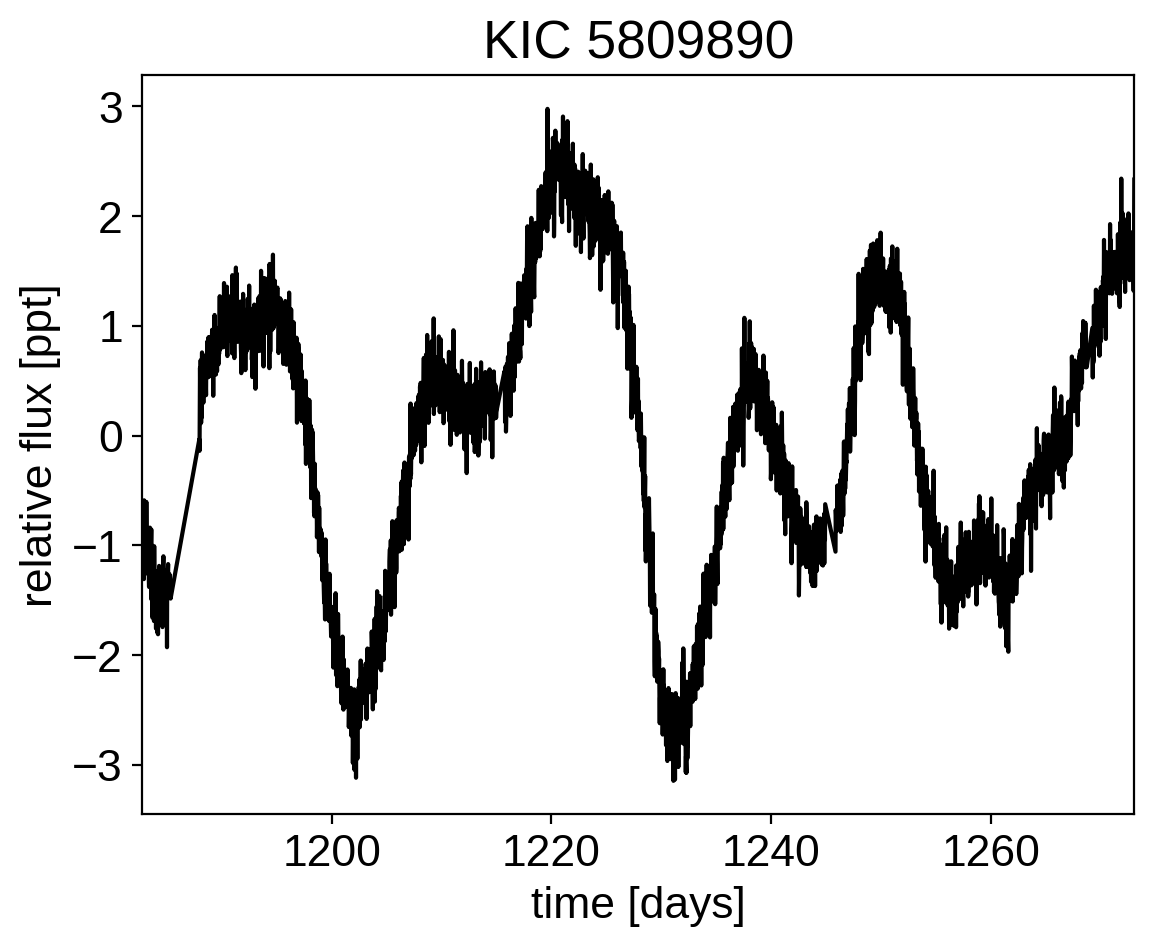

In [3]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

lcf = lk.search_lightcurvefile("KIC 5809890", quarter=13).download(
    quality_bitmask="hardest"
)
lc = lcf.PDCSAP_FLUX.normalize().remove_nans().remove_outliers()

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

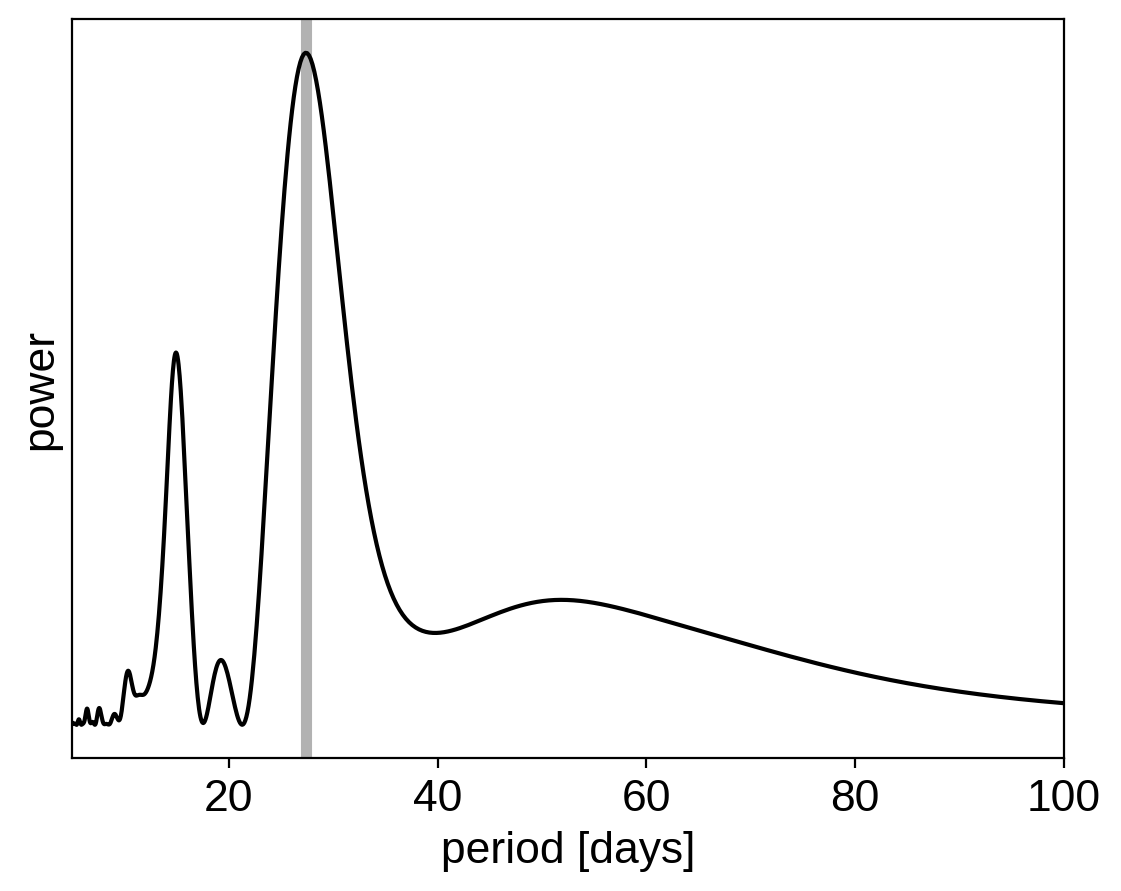

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(yerr)), sd=2.0)

    # A term to describe the non-periodic variability
    logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y)), sd=5.0)
    logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
    logperiod = BoundedNormal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = xo.distributions.UnitUniform("mix")

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
    kernel += xo.gp.terms.RotationTerm(
        log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr ** 2 + tt.exp(logs2), mean=mean)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.672569e+02]

1it [00:00, 73.22it/s, logp=2.672569e+02]

2it [00:00, 91.38it/s, logp=2.672569e+02]

3it [00:00, 104.16it/s, logp=5.136323e+02]

4it [00:00, 112.80it/s, logp=1.156425e+02]

5it [00:00, 123.87it/s, logp=5.979256e+02]

6it [00:00, 131.79it/s, logp=5.714984e+02]

7it [00:00, 139.41it/s, logp=6.326147e+02]

8it [00:00, 145.23it/s, logp=6.068474e+02]

9it [00:00, 150.52it/s, logp=6.417452e+02]

10it [00:00, 154.79it/s, logp=6.581322e+02]

11it [00:00, 158.49it/s, logp=6.674794e+02]

12it [00:00, 161.71it/s, logp=6.613014e+02]

13it [00:00, 164.82it/s, logp=6.757355e+02]

14it [00:00, 167.76it/s, logp=6.789136e+02]

15it [00:00, 161.72it/s, logp=6.838594e+02]

16it [00:00, 157.14it/s, logp=6.861378e+02]

17it [00:00, 164.61it/s, logp=6.861378e+02]

17it [00:00, 164.61it/s, logp=6.865861e+02]

18it [00:00, 164.61it/s, logp=6.871456e+02]

19it [00:00, 164.61it/s, logp=6.876705e+02]

20it [00:00, 164.61it/s, logp=6.876475e+02]

21it [00:00, 164.61it/s, logp=6.878897e+02]

22it [00:00, 164.61it/s, logp=6.881082e+02]

23it [00:00, 164.61it/s, logp=6.885047e+02]

24it [00:00, 164.61it/s, logp=6.891367e+02]

25it [00:00, 164.61it/s, logp=6.901976e+02]

26it [00:00, 164.61it/s, logp=6.909579e+02]

27it [00:00, 164.61it/s, logp=6.916029e+02]

28it [00:00, 164.61it/s, logp=6.920778e+02]

29it [00:00, 144.94it/s, logp=6.920778e+02]

29it [00:00, 144.94it/s, logp=6.924232e+02]

30it [00:00, 144.94it/s, logp=6.931739e+02]

31it [00:00, 144.94it/s, logp=6.904351e+02]

32it [00:00, 144.94it/s, logp=6.938593e+02]

33it [00:00, 144.94it/s, logp=6.905908e+02]

34it [00:00, 144.94it/s, logp=6.946127e+02]

35it [00:00, 144.94it/s, logp=6.956242e+02]

36it [00:00, 144.94it/s, logp=6.968903e+02]

37it [00:00, 144.94it/s, logp=6.985163e+02]

38it [00:00, 144.94it/s, logp=6.996495e+02]

39it [00:00, 144.94it/s, logp=6.999618e+02]

40it [00:00, 144.94it/s, logp=7.002774e+02]

41it [00:00, 144.94it/s, logp=7.005226e+02]

42it [00:00, 144.94it/s, logp=7.006902e+02]

43it [00:00, 144.94it/s, logp=7.009344e+02]

44it [00:00, 144.94it/s, logp=7.010994e+02]

45it [00:00, 144.94it/s, logp=7.012373e+02]

46it [00:00, 144.94it/s, logp=7.013984e+02]

47it [00:00, 152.70it/s, logp=7.013984e+02]

47it [00:00, 152.70it/s, logp=7.014793e+02]

48it [00:00, 152.70it/s, logp=7.015101e+02]

49it [00:00, 152.70it/s, logp=7.015675e+02]

50it [00:00, 152.70it/s, logp=7.016709e+02]

51it [00:00, 152.70it/s, logp=7.018428e+02]

52it [00:00, 152.70it/s, logp=7.020862e+02]

53it [00:00, 152.70it/s, logp=7.023418e+02]

54it [00:00, 152.70it/s, logp=7.026745e+02]

55it [00:00, 152.70it/s, logp=7.025408e+02]

56it [00:00, 152.70it/s, logp=7.010859e+02]

57it [00:00, 152.70it/s, logp=7.026189e+02]

58it [00:00, 152.70it/s, logp=7.025624e+02]

59it [00:00, 152.70it/s, logp=7.026910e+02]

60it [00:00, 152.70it/s, logp=7.025332e+02]

61it [00:00, 152.70it/s, logp=7.027220e+02]

62it [00:00, 152.70it/s, logp=7.027819e+02]

63it [00:00, 152.70it/s, logp=7.029662e+02]

64it [00:00, 152.70it/s, logp=7.029378e+02]

65it [00:00, 152.70it/s, logp=7.031062e+02]

66it [00:00, 152.70it/s, logp=7.031349e+02]

67it [00:00, 152.70it/s, logp=7.031669e+02]

68it [00:00, 165.60it/s, logp=7.031669e+02]

68it [00:00, 165.60it/s, logp=7.031683e+02]

69it [00:00, 165.60it/s, logp=7.031700e+02]

70it [00:00, 165.60it/s, logp=7.031704e+02]

71it [00:00, 165.60it/s, logp=7.031712e+02]

72it [00:00, 165.60it/s, logp=7.031720e+02]

73it [00:00, 165.60it/s, logp=7.031723e+02]

74it [00:00, 165.60it/s, logp=7.031724e+02]

75it [00:00, 165.60it/s, logp=7.031724e+02]

76it [00:00, 165.60it/s, logp=7.031724e+02]

77it [00:00, 165.60it/s, logp=7.031724e+02]

78it [00:00, 165.60it/s, logp=7.031724e+02]

79it [00:00, 165.60it/s, logp=7.031724e+02]

80it [00:00, 165.60it/s, logp=7.031724e+02]

81it [00:10,  7.61it/s, logp=7.031724e+02] 


message: Optimization terminated successfully.
logp: 267.25686032199354 -> 703.1723809089816


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

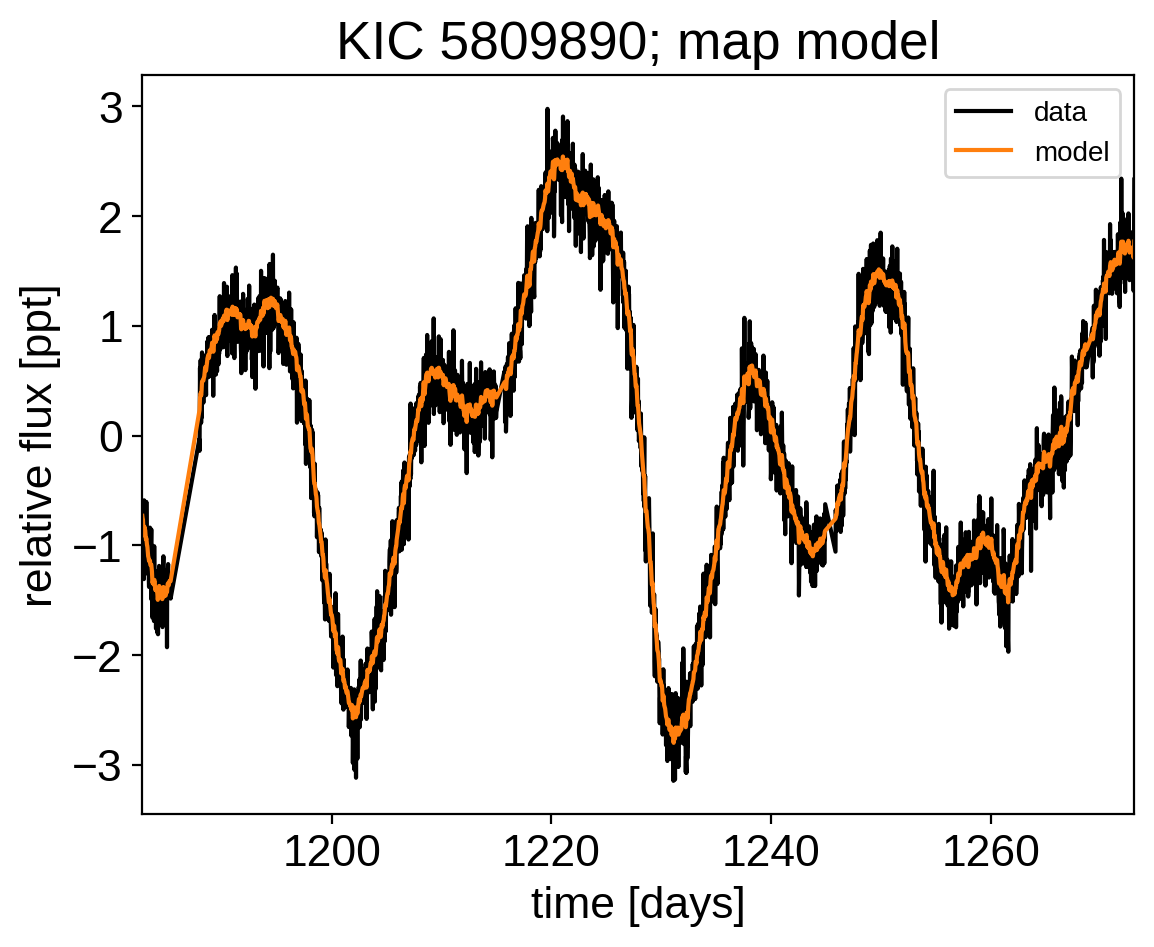

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

That looks pretty good!
Now let's sample from the posterior using :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=map_soln,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 9/16000 [00:00<05:39, 47.17draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 11/16000 [00:00<13:55, 19.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 13/16000 [00:00<29:42,  8.97draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 14/16000 [00:01<35:24,  7.52draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 15/16000 [00:01<38:16,  6.96draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 17/16000 [00:01<49:57,  5.33draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 19/16000 [00:01<39:26,  6.75draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 21/16000 [00:02<39:20,  6.77draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 23/16000 [00:02<47:20,  5.62draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 24/16000 [00:02<41:44,  6.38draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 26/16000 [00:03<48:09,  5.53draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 28/16000 [00:03<48:34,  5.48draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 30/16000 [00:03<39:49,  6.68draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 31/16000 [00:04<47:18,  5.63draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 32/16000 [00:04<53:11,  5.00draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/16000 [00:04<1:04:46,  4.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 36/16000 [00:05<1:02:27,  4.26draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/16000 [00:05<1:12:43,  3.66draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 40/16000 [00:05<54:21,  4.89draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 41/16000 [00:05<47:56,  5.55draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 42/16000 [00:06<43:40,  6.09draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 43/16000 [00:06<39:59,  6.65draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 45/16000 [00:06<37:44,  7.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 47/16000 [00:06<37:21,  7.12draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 48/16000 [00:06<45:21,  5.86draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 49/16000 [00:07<46:33,  5.71draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 50/16000 [00:07<43:05,  6.17draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 51/16000 [00:07<41:42,  6.37draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 53/16000 [00:07<38:02,  6.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 55/16000 [00:07<31:51,  8.34draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 57/16000 [00:07<27:39,  9.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 59/16000 [00:08<28:33,  9.30draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 61/16000 [00:08<25:21, 10.48draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 63/16000 [00:08<22:22, 11.87draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 65/16000 [00:08<25:30, 10.41draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 67/16000 [00:08<27:46,  9.56draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 69/16000 [00:09<34:09,  7.77draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/16000 [00:09<26:49,  9.90draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 75/16000 [00:09<28:22,  9.35draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/16000 [00:10<30:37,  8.67draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 79/16000 [00:10<36:51,  7.20draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 80/16000 [00:10<55:14,  4.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 81/16000 [00:10<49:00,  5.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 82/16000 [00:11<42:23,  6.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 83/16000 [00:11<41:17,  6.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 84/16000 [00:11<36:57,  7.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 86/16000 [00:11<35:44,  7.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 88/16000 [00:11<31:00,  8.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 90/16000 [00:11<28:08,  9.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 92/16000 [00:12<39:34,  6.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 93/16000 [00:12<39:03,  6.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 95/16000 [00:12<31:44,  8.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 97/16000 [00:12<30:28,  8.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 99/16000 [00:13<38:36,  6.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 100/16000 [00:13<35:23,  7.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 101/16000 [00:13<45:01,  5.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 102/16000 [00:13<39:52,  6.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 104/16000 [00:13<33:22,  7.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 106/16000 [00:13<29:17,  9.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 108/16000 [00:14<28:15,  9.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 110/16000 [00:14<25:54, 10.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 112/16000 [00:14<27:20,  9.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 115/16000 [00:14<26:14, 10.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 117/16000 [00:14<23:57, 11.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 119/16000 [00:15<28:33,  9.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 122/16000 [00:15<27:31,  9.61draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 124/16000 [00:15<24:12, 10.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 126/16000 [00:15<26:47,  9.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 128/16000 [00:16<29:45,  8.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 130/16000 [00:16<29:28,  8.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/16000 [00:16<27:03,  9.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/16000 [00:16<24:24, 10.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 136/16000 [00:17<34:32,  7.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/16000 [00:17<43:53,  6.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/16000 [00:17<45:00,  5.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 140/16000 [00:17<36:18,  7.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/16000 [00:18<40:21,  6.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 144/16000 [00:18<46:00,  5.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/16000 [00:18<38:45,  6.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 147/16000 [00:18<41:54,  6.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/16000 [00:19<35:51,  7.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 152/16000 [00:19<29:54,  8.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/16000 [00:19<29:44,  8.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/16000 [00:19<31:28,  8.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 157/16000 [00:19<40:29,  6.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 159/16000 [00:20<36:19,  7.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 163/16000 [00:20<30:56,  8.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 165/16000 [00:21<50:07,  5.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/16000 [00:21<42:13,  6.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 170/16000 [00:21<38:18,  6.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 171/16000 [00:21<51:46,  5.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 172/16000 [00:22<52:23,  5.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/16000 [00:22<55:35,  4.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 174/16000 [00:22<56:42,  4.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 175/16000 [00:22<1:04:26,  4.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 176/16000 [00:23<59:45,  4.41draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 177/16000 [00:23<1:01:50,  4.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/16000 [00:23<49:50,  5.29draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 181/16000 [00:23<58:53,  4.48draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/16000 [00:24<53:59,  4.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 185/16000 [00:24<44:10,  5.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 189/16000 [00:24<37:33,  7.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 191/16000 [00:24<36:04,  7.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 194/16000 [00:25<33:15,  7.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 197/16000 [00:25<28:14,  9.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/16000 [00:25<27:31,  9.57draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 201/16000 [00:25<26:20,  9.99draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 204/16000 [00:25<21:29, 12.25draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 206/16000 [00:26<20:00, 13.16draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 209/16000 [00:26<17:12, 15.29draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 211/16000 [00:26<21:46, 12.09draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 213/16000 [00:26<20:09, 13.05draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 216/16000 [00:26<20:09, 13.05draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 219/16000 [00:26<18:51, 13.94draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 221/16000 [00:27<20:25, 12.87draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 224/16000 [00:27<20:39, 12.73draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 226/16000 [00:27<18:26, 14.25draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 228/16000 [00:27<18:21, 14.32draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 230/16000 [00:27<20:25, 12.87draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 232/16000 [00:27<19:30, 13.47draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 234/16000 [00:28<19:51, 13.23draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 236/16000 [00:28<21:50, 12.03draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 238/16000 [00:28<29:59,  8.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 240/16000 [00:28<30:54,  8.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 241/16000 [00:29<31:59,  8.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 244/16000 [00:29<36:28,  7.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 246/16000 [00:29<38:18,  6.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 247/16000 [00:30<36:27,  7.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 250/16000 [00:30<28:48,  9.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 252/16000 [00:30<26:16,  9.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 254/16000 [00:30<26:44,  9.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 256/16000 [00:30<23:41, 11.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 258/16000 [00:30<21:33, 12.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 261/16000 [00:30<18:15, 14.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 263/16000 [00:31<18:08, 14.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 265/16000 [00:31<21:51, 12.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 267/16000 [00:31<25:11, 10.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 269/16000 [00:31<22:14, 11.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 271/16000 [00:31<27:17,  9.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 273/16000 [00:32<26:32,  9.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 275/16000 [00:32<23:13, 11.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 277/16000 [00:32<23:27, 11.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 279/16000 [00:32<23:44, 11.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 281/16000 [00:32<26:12, 10.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 283/16000 [00:32<22:43, 11.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 286/16000 [00:33<27:24,  9.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 290/16000 [00:33<22:48, 11.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 292/16000 [00:33<27:53,  9.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 294/16000 [00:33<23:32, 11.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 296/16000 [00:34<22:16, 11.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 299/16000 [00:34<18:39, 14.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 301/16000 [00:34<20:44, 12.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 303/16000 [00:34<22:35, 11.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 305/16000 [00:34<20:08, 12.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 309/16000 [00:34<16:20, 16.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 312/16000 [00:35<14:44, 17.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 315/16000 [00:35<19:11, 13.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 317/16000 [00:35<22:05, 11.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 320/16000 [00:35<22:23, 11.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 322/16000 [00:36<25:05, 10.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 325/16000 [00:36<25:16, 10.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 327/16000 [00:36<27:28,  9.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 330/16000 [00:36<22:33, 11.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 332/16000 [00:36<23:37, 11.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 335/16000 [00:37<21:01, 12.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 337/16000 [00:37<21:51, 11.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 339/16000 [00:37<20:25, 12.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 341/16000 [00:37<18:55, 13.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 343/16000 [00:37<18:21, 14.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 345/16000 [00:37<18:26, 14.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 348/16000 [00:37<16:01, 16.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 350/16000 [00:38<20:14, 12.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 352/16000 [00:38<22:16, 11.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 354/16000 [00:38<25:14, 10.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 356/16000 [00:38<27:15,  9.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 358/16000 [00:39<30:36,  8.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 359/16000 [00:39<36:10,  7.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 362/16000 [00:39<32:23,  8.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 364/16000 [00:39<27:32,  9.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 366/16000 [00:39<23:48, 10.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 368/16000 [00:40<21:54, 11.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 370/16000 [00:40<23:21, 11.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 372/16000 [00:40<21:12, 12.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 374/16000 [00:40<24:39, 10.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 376/16000 [00:40<25:29, 10.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 379/16000 [00:40<20:44, 12.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 381/16000 [00:41<18:40, 13.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 383/16000 [00:41<18:57, 13.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 386/16000 [00:41<16:13, 16.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 390/16000 [00:41<15:18, 16.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 393/16000 [00:41<13:53, 18.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 396/16000 [00:41<14:22, 18.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 399/16000 [00:41<13:25, 19.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 402/16000 [00:42<13:30, 19.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 405/16000 [00:42<12:35, 20.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 409/16000 [00:42<11:15, 23.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 412/16000 [00:42<12:05, 21.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 416/16000 [00:42<11:19, 22.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 419/16000 [00:42<11:07, 23.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 422/16000 [00:42<13:20, 19.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 425/16000 [00:43<13:22, 19.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 428/16000 [00:43<12:34, 20.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 431/16000 [00:43<12:47, 20.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 436/16000 [00:43<10:45, 24.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 439/16000 [00:43<11:04, 23.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 442/16000 [00:43<11:00, 23.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 445/16000 [00:43<10:52, 23.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 449/16000 [00:44<09:57, 26.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 452/16000 [00:44<10:16, 25.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 456/16000 [00:44<09:32, 27.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 462/16000 [00:44<08:18, 31.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 467/16000 [00:44<07:38, 33.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 472/16000 [00:44<06:56, 37.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 477/16000 [00:44<06:48, 38.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 482/16000 [00:44<06:32, 39.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 487/16000 [00:45<06:53, 37.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 492/16000 [00:45<06:23, 40.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 497/16000 [00:45<07:18, 35.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 501/16000 [00:45<08:37, 29.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 505/16000 [00:45<08:24, 30.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 509/16000 [00:45<08:47, 29.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 514/16000 [00:45<07:52, 32.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 518/16000 [00:45<07:38, 33.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 524/16000 [00:46<06:40, 38.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 529/16000 [00:46<06:34, 39.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 534/16000 [00:46<07:20, 35.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 538/16000 [00:46<07:26, 34.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 542/16000 [00:46<07:40, 33.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 547/16000 [00:46<07:16, 35.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 555/16000 [00:46<06:10, 41.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 560/16000 [00:47<06:54, 37.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 565/16000 [00:47<06:38, 38.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 570/16000 [00:47<06:18, 40.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 576/16000 [00:47<05:58, 43.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 581/16000 [00:47<06:32, 39.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 586/16000 [00:47<06:11, 41.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 591/16000 [00:47<05:58, 42.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 596/16000 [00:47<05:51, 43.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 601/16000 [00:47<05:40, 45.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 608/16000 [00:48<05:13, 49.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 616/16000 [00:48<04:49, 53.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 622/16000 [00:48<05:11, 49.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 628/16000 [00:48<04:59, 51.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 634/16000 [00:48<05:32, 46.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 639/16000 [00:48<05:49, 44.01draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 644/16000 [00:48<05:46, 44.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 650/16000 [00:48<05:48, 44.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 655/16000 [00:49<05:54, 43.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 662/16000 [00:49<05:27, 46.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 669/16000 [00:49<05:15, 48.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 675/16000 [00:49<05:05, 50.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 682/16000 [00:49<04:48, 53.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 689/16000 [00:49<04:37, 55.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 695/16000 [00:49<04:48, 53.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 702/16000 [00:49<04:42, 54.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 708/16000 [00:50<04:52, 52.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 717/16000 [00:50<04:32, 56.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 723/16000 [00:50<04:45, 53.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 729/16000 [00:50<04:50, 52.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 735/16000 [00:50<05:53, 43.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 740/16000 [00:50<06:04, 41.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 745/16000 [00:50<07:19, 34.71draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 753/16000 [00:51<06:31, 38.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 761/16000 [00:51<05:44, 44.26draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 768/16000 [00:51<05:19, 47.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 776/16000 [00:51<04:53, 51.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 782/16000 [00:51<04:55, 51.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 788/16000 [00:51<04:43, 53.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 794/16000 [00:51<04:52, 52.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 801/16000 [00:51<04:44, 53.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 808/16000 [00:52<04:30, 56.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 815/16000 [00:52<04:18, 58.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 821/16000 [00:52<04:20, 58.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 827/16000 [00:52<04:43, 53.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 833/16000 [00:52<04:52, 51.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 839/16000 [00:52<04:42, 53.61draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 845/16000 [00:52<05:06, 49.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 851/16000 [00:52<05:14, 48.11draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 856/16000 [00:53<05:33, 45.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 861/16000 [00:53<05:38, 44.72draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 866/16000 [00:53<05:47, 43.61draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 871/16000 [00:53<05:50, 43.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 877/16000 [00:53<05:34, 45.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 885/16000 [00:53<04:50, 51.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 891/16000 [00:53<04:49, 52.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 897/16000 [00:53<04:54, 51.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 903/16000 [00:53<04:43, 53.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 909/16000 [00:54<04:52, 51.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 916/16000 [00:54<04:46, 52.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 923/16000 [00:54<04:26, 56.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 929/16000 [00:54<04:37, 54.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 936/16000 [00:54<04:35, 54.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 942/16000 [00:54<04:32, 55.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 948/16000 [00:54<04:56, 50.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 954/16000 [00:54<04:46, 52.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 960/16000 [00:55<05:01, 49.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 967/16000 [00:55<04:44, 52.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 973/16000 [00:55<05:13, 47.90draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 979/16000 [00:55<05:12, 48.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 985/16000 [00:55<04:53, 51.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 991/16000 [00:55<04:56, 50.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 997/16000 [00:55<04:58, 50.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1003/16000 [00:55<05:23, 46.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1008/16000 [00:55<05:20, 46.76draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1015/16000 [00:56<04:55, 50.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1021/16000 [00:56<04:45, 52.48draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1028/16000 [00:56<04:36, 54.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1035/16000 [00:56<04:29, 55.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1042/16000 [00:56<04:26, 56.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1049/16000 [00:56<04:23, 56.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1057/16000 [00:56<04:14, 58.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1063/16000 [00:56<04:29, 55.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1069/16000 [00:57<05:01, 49.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1075/16000 [00:57<05:42, 43.60draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1080/16000 [00:57<05:47, 42.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1085/16000 [00:57<05:54, 42.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1090/16000 [00:57<06:44, 36.85draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1094/16000 [00:57<06:51, 36.20draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1099/16000 [00:57<06:19, 39.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1104/16000 [00:58<06:12, 39.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1109/16000 [00:58<06:38, 37.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1113/16000 [00:58<06:57, 35.63draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1119/16000 [00:58<06:08, 40.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1125/16000 [00:58<05:47, 42.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1131/16000 [00:58<05:19, 46.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1137/16000 [00:58<05:07, 48.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1143/16000 [00:58<05:01, 49.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1150/16000 [00:58<04:36, 53.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1156/16000 [00:59<04:56, 50.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1162/16000 [00:59<04:57, 49.85draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1168/16000 [00:59<04:42, 52.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1174/16000 [00:59<04:48, 51.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1180/16000 [00:59<04:36, 53.54draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1186/16000 [00:59<05:07, 48.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1193/16000 [00:59<04:53, 50.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1199/16000 [00:59<05:19, 46.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1204/16000 [01:00<05:13, 47.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1209/16000 [01:00<05:25, 45.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1214/16000 [01:00<05:33, 44.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1219/16000 [01:00<05:36, 43.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1224/16000 [01:00<05:41, 43.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1231/16000 [01:00<05:15, 46.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1239/16000 [01:00<04:48, 51.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1245/16000 [01:00<04:49, 50.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1251/16000 [01:01<04:41, 52.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1257/16000 [01:01<04:49, 50.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1263/16000 [01:01<04:59, 49.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1268/16000 [01:01<05:41, 43.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1273/16000 [01:01<05:48, 42.32draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1279/16000 [01:01<05:35, 43.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1285/16000 [01:01<05:24, 45.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1292/16000 [01:01<04:58, 49.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1299/16000 [01:02<04:32, 54.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1305/16000 [01:02<04:39, 52.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1311/16000 [01:02<04:57, 49.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1317/16000 [01:02<04:56, 49.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1324/16000 [01:02<04:45, 51.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1331/16000 [01:02<04:54, 49.89draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1337/16000 [01:02<04:55, 49.63draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1343/16000 [01:02<05:01, 48.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1351/16000 [01:03<04:38, 52.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1357/16000 [01:03<04:54, 49.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1363/16000 [01:03<05:00, 48.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1368/16000 [01:03<05:11, 46.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1375/16000 [01:03<04:58, 48.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1380/16000 [01:03<05:09, 47.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1386/16000 [01:03<05:08, 47.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1393/16000 [01:03<04:52, 49.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1399/16000 [01:04<05:18, 45.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1405/16000 [01:04<05:21, 45.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1410/16000 [01:04<05:36, 43.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1415/16000 [01:04<05:45, 42.27draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1420/16000 [01:04<05:54, 41.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1427/16000 [01:04<05:30, 44.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1434/16000 [01:04<04:54, 49.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1440/16000 [01:04<04:51, 49.97draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1447/16000 [01:05<04:40, 51.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1455/16000 [01:05<04:19, 55.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1461/16000 [01:05<04:40, 51.87draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1467/16000 [01:05<04:45, 50.87draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1473/16000 [01:05<04:36, 52.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1479/16000 [01:05<04:37, 52.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1485/16000 [01:05<04:34, 52.86draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1491/16000 [01:05<04:41, 51.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1498/16000 [01:05<04:24, 54.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1504/16000 [01:06<04:33, 52.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1510/16000 [01:06<04:31, 53.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1516/16000 [01:06<04:48, 50.29draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1522/16000 [01:06<04:41, 51.40draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1528/16000 [01:06<04:50, 49.84draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1534/16000 [01:06<05:20, 45.11draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1539/16000 [01:06<05:33, 43.38draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1546/16000 [01:06<04:56, 48.70draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1552/16000 [01:07<04:42, 51.23draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1558/16000 [01:07<04:37, 52.10draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1565/16000 [01:07<04:35, 52.47draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1571/16000 [01:07<05:22, 44.69draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1577/16000 [01:07<05:14, 45.91draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1583/16000 [01:07<05:01, 47.83draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1588/16000 [01:07<05:17, 45.39draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1593/16000 [01:08<05:44, 41.76draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1598/16000 [01:08<06:58, 34.38draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1603/16000 [01:08<06:39, 36.07draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1608/16000 [01:08<06:28, 37.04draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1615/16000 [01:08<05:49, 41.21draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1621/16000 [01:08<05:27, 43.96draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1628/16000 [01:08<04:52, 49.17draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1634/16000 [01:08<05:04, 47.21draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1639/16000 [01:09<05:25, 44.18draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1645/16000 [01:09<05:04, 47.16draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1651/16000 [01:09<04:47, 49.99draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1657/16000 [01:09<04:52, 49.05draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1664/16000 [01:09<04:34, 52.15draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1670/16000 [01:09<04:41, 50.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1676/16000 [01:09<04:55, 48.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1684/16000 [01:09<04:42, 50.59draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1691/16000 [01:10<04:26, 53.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1697/16000 [01:10<04:34, 52.06draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1703/16000 [01:10<04:52, 48.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1708/16000 [01:10<05:11, 45.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1713/16000 [01:10<05:59, 39.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1719/16000 [01:10<05:34, 42.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1724/16000 [01:10<05:46, 41.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1729/16000 [01:10<05:46, 41.22draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1734/16000 [01:11<06:30, 36.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1738/16000 [01:11<06:43, 35.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1744/16000 [01:11<06:08, 38.69draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1749/16000 [01:11<06:23, 37.13draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1754/16000 [01:11<06:08, 38.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1759/16000 [01:11<06:04, 39.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1766/16000 [01:11<05:30, 43.08draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1771/16000 [01:12<05:57, 39.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1776/16000 [01:12<05:57, 39.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1782/16000 [01:12<05:39, 41.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1787/16000 [01:12<05:44, 41.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1792/16000 [01:12<05:50, 40.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1798/16000 [01:12<05:34, 42.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1804/16000 [01:12<05:18, 44.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1809/16000 [01:12<05:55, 39.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1815/16000 [01:13<05:20, 44.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1821/16000 [01:13<04:57, 47.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1827/16000 [01:13<04:43, 50.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1833/16000 [01:13<04:57, 47.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1838/16000 [01:13<05:10, 45.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1843/16000 [01:13<05:18, 44.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1848/16000 [01:13<05:30, 42.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1853/16000 [01:13<05:30, 42.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1858/16000 [01:14<05:34, 42.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1863/16000 [01:14<05:59, 39.36draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1868/16000 [01:14<05:44, 41.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1874/16000 [01:14<05:29, 42.91draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1879/16000 [01:14<05:15, 44.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1885/16000 [01:14<05:06, 46.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1890/16000 [01:14<05:18, 44.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1895/16000 [01:14<05:30, 42.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1901/16000 [01:14<05:04, 46.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1906/16000 [01:15<05:19, 44.12draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1911/16000 [01:15<05:46, 40.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1916/16000 [01:15<05:47, 40.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1924/16000 [01:15<05:28, 42.91draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1929/16000 [01:15<05:33, 42.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1936/16000 [01:15<05:08, 45.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1941/16000 [01:15<05:22, 43.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1946/16000 [01:16<05:14, 44.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1953/16000 [01:16<04:48, 48.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1960/16000 [01:16<04:23, 53.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1966/16000 [01:16<04:29, 52.07draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1972/16000 [01:16<04:33, 51.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1979/16000 [01:16<04:44, 49.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1985/16000 [01:16<04:45, 49.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1991/16000 [01:16<04:54, 47.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1996/16000 [01:17<05:11, 44.99draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2002/16000 [01:17<04:57, 47.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2007/16000 [01:17<05:04, 45.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2014/16000 [01:17<04:51, 47.94draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2020/16000 [01:17<04:54, 47.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2025/16000 [01:17<05:10, 45.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2030/16000 [01:17<05:28, 42.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2035/16000 [01:17<05:28, 42.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2040/16000 [01:18<06:00, 38.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2046/16000 [01:18<05:35, 41.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2052/16000 [01:18<05:18, 43.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2059/16000 [01:18<04:43, 49.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2065/16000 [01:18<04:45, 48.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2072/16000 [01:18<04:32, 51.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2078/16000 [01:18<04:35, 50.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2084/16000 [01:18<04:22, 52.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2091/16000 [01:18<04:09, 55.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2098/16000 [01:19<03:56, 58.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2104/16000 [01:19<04:14, 54.53draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2111/16000 [01:19<04:11, 55.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2117/16000 [01:19<04:21, 53.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2125/16000 [01:19<04:10, 55.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2131/16000 [01:19<04:21, 53.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2137/16000 [01:19<04:20, 53.23draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2143/16000 [01:19<04:41, 49.14draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2149/16000 [01:20<04:46, 48.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2155/16000 [01:20<04:53, 47.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2161/16000 [01:20<04:36, 50.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2167/16000 [01:20<04:50, 47.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2172/16000 [01:20<05:20, 43.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2179/16000 [01:20<05:05, 45.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2186/16000 [01:20<04:50, 47.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2191/16000 [01:20<05:01, 45.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2196/16000 [01:21<05:27, 42.12draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2201/16000 [01:21<06:05, 37.74draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2207/16000 [01:21<05:42, 40.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2214/16000 [01:21<05:22, 42.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2219/16000 [01:21<05:17, 43.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2224/16000 [01:21<05:08, 44.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2229/16000 [01:21<05:18, 43.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2234/16000 [01:22<05:59, 38.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2239/16000 [01:22<05:38, 40.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2244/16000 [01:22<05:38, 40.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2249/16000 [01:22<05:33, 41.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2254/16000 [01:22<05:34, 41.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2259/16000 [01:22<05:36, 40.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2264/16000 [01:22<05:19, 43.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2271/16000 [01:22<05:00, 45.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2278/16000 [01:23<05:05, 44.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2285/16000 [01:23<04:59, 45.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2291/16000 [01:23<04:55, 46.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2296/16000 [01:23<06:03, 37.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2303/16000 [01:23<05:36, 40.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2309/16000 [01:23<05:08, 44.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2314/16000 [01:23<05:09, 44.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2320/16000 [01:24<05:17, 43.07draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2326/16000 [01:24<05:36, 40.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2331/16000 [01:24<05:37, 40.49draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2336/16000 [01:24<05:53, 38.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2342/16000 [01:24<05:25, 41.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2347/16000 [01:24<05:23, 42.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2352/16000 [01:24<05:21, 42.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2357/16000 [01:24<05:08, 44.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2362/16000 [01:25<05:09, 44.03draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2367/16000 [01:25<06:31, 34.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2372/16000 [01:25<06:38, 34.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2376/16000 [01:25<06:49, 33.29draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2380/16000 [01:25<08:14, 27.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2385/16000 [01:25<07:15, 31.29draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2389/16000 [01:25<06:49, 33.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2394/16000 [01:26<06:08, 36.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2399/16000 [01:26<06:07, 36.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2404/16000 [01:26<05:49, 38.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2410/16000 [01:26<05:29, 41.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2415/16000 [01:26<05:38, 40.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2421/16000 [01:26<05:08, 43.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2427/16000 [01:26<04:49, 46.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2432/16000 [01:26<05:09, 43.79draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2437/16000 [01:26<05:25, 41.63draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2442/16000 [01:27<05:43, 39.50draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2447/16000 [01:27<05:24, 41.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2453/16000 [01:27<05:12, 43.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2459/16000 [01:27<04:59, 45.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2464/16000 [01:27<05:02, 44.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2469/16000 [01:27<05:22, 41.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2474/16000 [01:27<05:30, 40.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2479/16000 [01:28<05:45, 39.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2483/16000 [01:28<06:17, 35.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2490/16000 [01:28<05:43, 39.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2495/16000 [01:28<05:31, 40.76draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2500/16000 [01:28<05:18, 42.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2506/16000 [01:28<04:51, 46.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2511/16000 [01:28<05:02, 44.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2516/16000 [01:28<05:08, 43.70draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2522/16000 [01:28<05:04, 44.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2528/16000 [01:29<04:41, 47.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2533/16000 [01:29<04:59, 44.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2538/16000 [01:29<05:19, 42.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2543/16000 [01:29<05:11, 43.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2549/16000 [01:29<05:17, 42.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2554/16000 [01:29<05:18, 42.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2559/16000 [01:29<05:37, 39.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2564/16000 [01:29<05:26, 41.12draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2569/16000 [01:30<05:29, 40.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2574/16000 [01:30<05:46, 38.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2580/16000 [01:30<05:17, 42.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2587/16000 [01:30<04:50, 46.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2593/16000 [01:30<04:31, 49.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2599/16000 [01:30<04:57, 45.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2604/16000 [01:30<05:09, 43.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2610/16000 [01:30<04:51, 45.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2616/16000 [01:31<04:34, 48.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2622/16000 [01:31<05:02, 44.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2627/16000 [01:31<05:19, 41.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2634/16000 [01:31<04:48, 46.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2639/16000 [01:31<05:14, 42.47draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2644/16000 [01:31<05:39, 39.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2649/16000 [01:31<05:46, 38.51draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2654/16000 [01:32<05:54, 37.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2658/16000 [01:32<06:39, 33.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2662/16000 [01:32<07:18, 30.44draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2666/16000 [01:32<07:28, 29.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2672/16000 [01:32<06:24, 34.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2676/16000 [01:32<06:11, 35.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2680/16000 [01:32<06:04, 36.54draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2686/16000 [01:32<05:43, 38.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2692/16000 [01:33<05:08, 43.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2698/16000 [01:33<05:05, 43.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2703/16000 [01:33<04:56, 44.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2708/16000 [01:33<05:41, 38.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2713/16000 [01:33<06:14, 35.49draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2719/16000 [01:33<05:36, 39.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2725/16000 [01:33<05:11, 42.65draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2730/16000 [01:33<05:09, 42.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2735/16000 [01:34<05:03, 43.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2741/16000 [01:34<04:46, 46.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2746/16000 [01:34<04:51, 45.52draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2751/16000 [01:34<04:48, 45.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2758/16000 [01:34<04:21, 50.55draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2764/16000 [01:34<04:20, 50.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2770/16000 [01:34<04:56, 44.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2776/16000 [01:34<04:56, 44.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2782/16000 [01:35<04:36, 47.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2790/16000 [01:35<04:10, 52.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2797/16000 [01:35<04:07, 53.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2803/16000 [01:35<04:26, 49.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2809/16000 [01:35<04:33, 48.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2815/16000 [01:35<04:41, 46.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2820/16000 [01:35<05:06, 42.96draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2825/16000 [01:35<05:04, 43.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2830/16000 [01:36<05:11, 42.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2835/16000 [01:36<06:55, 31.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2839/16000 [01:36<07:04, 31.02draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2844/16000 [01:36<06:36, 33.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2849/16000 [01:36<06:17, 34.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2853/16000 [01:36<06:39, 32.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2858/16000 [01:37<06:42, 32.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2863/16000 [01:37<06:02, 36.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2868/16000 [01:37<05:49, 37.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2873/16000 [01:37<05:41, 38.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2878/16000 [01:37<05:24, 40.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2883/16000 [01:37<05:08, 42.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2888/16000 [01:37<05:18, 41.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2894/16000 [01:37<05:16, 41.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2901/16000 [01:37<04:58, 43.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2906/16000 [01:38<04:50, 45.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2912/16000 [01:38<04:46, 45.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2917/16000 [01:38<04:52, 44.74draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2922/16000 [01:38<04:57, 43.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2927/16000 [01:38<05:13, 41.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2933/16000 [01:38<05:01, 43.33draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2938/16000 [01:38<04:55, 44.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2943/16000 [01:39<05:59, 36.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2948/16000 [01:39<05:35, 38.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2953/16000 [01:39<05:40, 38.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2957/16000 [01:39<05:53, 36.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2961/16000 [01:39<05:51, 37.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2967/16000 [01:39<05:37, 38.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2971/16000 [01:39<06:10, 35.18draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2975/16000 [01:39<06:27, 33.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2979/16000 [01:40<06:46, 32.07draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2983/16000 [01:40<06:54, 31.44draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2989/16000 [01:40<06:20, 34.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2995/16000 [01:40<06:01, 36.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3001/16000 [01:40<05:19, 40.75draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3006/16000 [01:40<06:05, 35.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3011/16000 [01:40<06:05, 35.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3015/16000 [01:40<06:01, 35.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3020/16000 [01:41<05:51, 36.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3025/16000 [01:41<05:23, 40.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3031/16000 [01:41<05:15, 41.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3037/16000 [01:41<04:51, 44.44draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3043/16000 [01:41<04:35, 46.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3048/16000 [01:41<04:37, 46.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3055/16000 [01:41<04:38, 46.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3062/16000 [01:41<04:18, 50.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3068/16000 [01:42<04:24, 48.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3074/16000 [01:42<04:14, 50.85draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3080/16000 [01:42<04:28, 48.08draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3085/16000 [01:42<04:29, 47.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3090/16000 [01:42<04:32, 47.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3095/16000 [01:42<04:35, 46.85draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3100/16000 [01:42<04:46, 45.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3105/16000 [01:42<04:42, 45.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3111/16000 [01:42<04:27, 48.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3116/16000 [01:43<04:49, 44.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3123/16000 [01:43<04:23, 48.89draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3129/16000 [01:43<04:52, 44.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3134/16000 [01:43<04:42, 45.61draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3139/16000 [01:43<05:10, 41.38draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3144/16000 [01:43<05:15, 40.75draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3149/16000 [01:43<05:38, 37.94draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3153/16000 [01:44<06:40, 32.05draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3158/16000 [01:44<06:02, 35.39draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3162/16000 [01:44<06:07, 34.90draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3166/16000 [01:44<06:12, 34.43draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3172/16000 [01:44<05:40, 37.64draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3176/16000 [01:44<05:42, 37.41draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3180/16000 [01:44<05:40, 37.68draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3184/16000 [01:44<05:44, 37.16draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3188/16000 [01:45<06:05, 35.07draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3192/16000 [01:45<06:23, 33.36draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3198/16000 [01:45<06:09, 34.69draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3202/16000 [01:45<06:11, 34.42draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3206/16000 [01:45<07:03, 30.19draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3212/16000 [01:45<06:21, 33.54draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3218/16000 [01:45<05:39, 37.68draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3223/16000 [01:46<06:12, 34.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3228/16000 [01:46<06:22, 33.42draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3232/16000 [01:46<06:24, 33.24draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3236/16000 [01:46<06:40, 31.91draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3241/16000 [01:46<06:23, 33.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3246/16000 [01:46<05:46, 36.78draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3251/16000 [01:46<06:06, 34.79draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3255/16000 [01:46<06:07, 34.70draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3260/16000 [01:47<05:34, 38.04draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3265/16000 [01:47<05:11, 40.83draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3270/16000 [01:47<05:54, 35.86draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3274/16000 [01:47<05:54, 35.93draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3279/16000 [01:47<05:44, 36.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3284/16000 [01:47<05:19, 39.85draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3290/16000 [01:47<05:22, 39.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3295/16000 [01:47<05:38, 37.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3300/16000 [01:48<05:57, 35.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3306/16000 [01:48<05:51, 36.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3310/16000 [01:48<06:24, 32.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3315/16000 [01:48<06:23, 33.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3320/16000 [01:48<06:00, 35.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3324/16000 [01:48<06:12, 33.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3328/16000 [01:48<06:34, 32.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3335/16000 [01:49<05:50, 36.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3341/16000 [01:49<05:15, 40.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3346/16000 [01:49<05:25, 38.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3351/16000 [01:49<05:55, 35.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3356/16000 [01:49<05:27, 38.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3362/16000 [01:49<05:03, 41.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3368/16000 [01:49<04:37, 45.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3373/16000 [01:49<04:54, 42.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3379/16000 [01:50<04:39, 45.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3384/16000 [01:50<05:20, 39.39draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3389/16000 [01:50<05:28, 38.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3394/16000 [01:50<05:34, 37.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3400/16000 [01:50<05:02, 41.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3406/16000 [01:50<05:00, 41.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3412/16000 [01:50<05:09, 40.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3418/16000 [01:51<04:49, 43.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3423/16000 [01:51<05:27, 38.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3428/16000 [01:51<05:46, 36.32draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3433/16000 [01:51<05:50, 35.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3439/16000 [01:51<05:44, 36.49draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3445/16000 [01:51<05:36, 37.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3452/16000 [01:51<05:05, 41.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3457/16000 [01:52<05:28, 38.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3461/16000 [01:52<05:37, 37.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3465/16000 [01:52<05:42, 36.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3469/16000 [01:52<05:36, 37.23draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3473/16000 [01:52<06:01, 34.65draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3479/16000 [01:52<05:32, 37.63draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3484/16000 [01:52<05:14, 39.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3490/16000 [01:52<04:48, 43.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3495/16000 [01:53<05:05, 40.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3500/16000 [01:53<05:36, 37.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3504/16000 [01:53<06:02, 34.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3508/16000 [01:53<06:05, 34.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3513/16000 [01:53<05:30, 37.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3519/16000 [01:53<05:13, 39.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3524/16000 [01:53<05:37, 36.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3528/16000 [01:54<05:59, 34.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3533/16000 [01:54<05:52, 35.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3538/16000 [01:54<05:41, 36.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3543/16000 [01:54<06:09, 33.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3550/16000 [01:54<05:15, 39.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3555/16000 [01:54<05:29, 37.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3560/16000 [01:54<05:55, 35.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3564/16000 [01:54<06:14, 33.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3569/16000 [01:55<05:43, 36.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3574/16000 [01:55<05:49, 35.51draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3579/16000 [01:55<05:21, 38.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3584/16000 [01:55<05:17, 39.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3589/16000 [01:55<05:58, 34.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3593/16000 [01:55<05:54, 35.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3597/16000 [01:55<05:52, 35.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3602/16000 [01:56<05:44, 36.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3608/16000 [01:56<05:17, 39.03draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3613/16000 [01:56<04:58, 41.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3618/16000 [01:56<04:49, 42.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3623/16000 [01:56<04:42, 43.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3628/16000 [01:56<04:58, 41.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3633/16000 [01:56<04:51, 42.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3638/16000 [01:56<04:48, 42.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3643/16000 [01:56<04:42, 43.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3648/16000 [01:57<04:49, 42.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3655/16000 [01:57<04:25, 46.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3661/16000 [01:57<04:09, 49.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3667/16000 [01:57<04:08, 49.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3673/16000 [01:57<04:24, 46.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3678/16000 [01:57<04:19, 47.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3684/16000 [01:57<04:16, 47.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3691/16000 [01:57<04:03, 50.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3697/16000 [01:57<03:53, 52.76draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3704/16000 [01:58<03:40, 55.79draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3710/16000 [01:58<03:40, 55.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3716/16000 [01:58<04:02, 50.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3722/16000 [01:58<04:15, 48.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3727/16000 [01:58<04:29, 45.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3733/16000 [01:58<04:11, 48.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3739/16000 [01:58<04:06, 49.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3745/16000 [01:58<04:24, 46.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3750/16000 [01:59<04:35, 44.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3756/16000 [01:59<04:37, 44.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3761/16000 [01:59<04:53, 41.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3766/16000 [01:59<05:03, 40.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3772/16000 [01:59<05:01, 40.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3778/16000 [01:59<04:42, 43.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3783/16000 [01:59<04:41, 43.41draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3788/16000 [02:00<04:48, 42.29draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3794/16000 [02:00<04:28, 45.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3800/16000 [02:00<04:32, 44.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3805/16000 [02:00<04:48, 42.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3811/16000 [02:00<04:49, 42.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3817/16000 [02:00<04:34, 44.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3822/16000 [02:00<05:03, 40.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3828/16000 [02:00<04:46, 42.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3834/16000 [02:01<04:22, 46.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3839/16000 [02:01<04:37, 43.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3845/16000 [02:01<04:19, 46.89draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3851/16000 [02:01<04:07, 49.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3857/16000 [02:01<04:18, 46.99draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3862/16000 [02:01<04:34, 44.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3867/16000 [02:01<04:39, 43.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3872/16000 [02:01<04:54, 41.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3877/16000 [02:02<05:00, 40.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3885/16000 [02:02<04:40, 43.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3891/16000 [02:02<04:41, 42.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3896/16000 [02:02<05:34, 36.23draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3901/16000 [02:02<05:15, 38.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3907/16000 [02:02<04:45, 42.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3912/16000 [02:02<04:32, 44.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3917/16000 [02:02<04:29, 44.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3922/16000 [02:03<04:26, 45.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3929/16000 [02:03<03:58, 50.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3935/16000 [02:03<04:17, 46.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3941/16000 [02:03<04:31, 44.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3947/16000 [02:03<04:26, 45.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3952/16000 [02:03<04:44, 42.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3957/16000 [02:03<04:51, 41.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3962/16000 [02:03<04:49, 41.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3967/16000 [02:04<05:14, 38.28draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3972/16000 [02:04<05:04, 39.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3977/16000 [02:04<05:05, 39.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3982/16000 [02:04<05:07, 39.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3987/16000 [02:04<04:54, 40.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3992/16000 [02:04<04:38, 43.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3997/16000 [02:04<05:08, 38.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4002/16000 [02:04<05:03, 39.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4007/16000 [02:05<05:03, 39.47draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4012/16000 [02:05<05:15, 37.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4016/16000 [02:05<05:18, 37.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4021/16000 [02:05<05:11, 38.41draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4025/16000 [02:05<05:55, 33.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4030/16000 [02:05<06:08, 32.47draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4035/16000 [02:05<05:30, 36.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4039/16000 [02:06<05:30, 36.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4043/16000 [02:06<05:45, 34.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4049/16000 [02:06<05:04, 39.26draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4054/16000 [02:06<04:51, 41.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4059/16000 [02:06<05:49, 34.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4064/16000 [02:06<05:18, 37.50draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4069/16000 [02:06<05:14, 37.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4074/16000 [02:06<04:52, 40.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4079/16000 [02:07<04:46, 41.58draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4084/16000 [02:07<05:03, 39.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4089/16000 [02:07<05:12, 38.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4094/16000 [02:07<04:59, 39.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4099/16000 [02:07<05:02, 39.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4105/16000 [02:07<04:56, 40.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4110/16000 [02:07<04:39, 42.56draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4115/16000 [02:07<04:54, 40.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4120/16000 [02:08<04:41, 42.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4126/16000 [02:08<04:34, 43.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4133/16000 [02:08<04:11, 47.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4139/16000 [02:08<04:01, 49.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4145/16000 [02:08<04:09, 47.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4151/16000 [02:08<04:00, 49.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4157/16000 [02:08<03:59, 49.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4165/16000 [02:08<03:49, 51.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4171/16000 [02:09<03:52, 50.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4177/16000 [02:09<04:17, 46.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4183/16000 [02:09<04:18, 45.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4188/16000 [02:09<04:32, 43.39draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4193/16000 [02:09<04:23, 44.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4199/16000 [02:09<04:26, 44.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4205/16000 [02:09<04:07, 47.62draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4210/16000 [02:09<04:19, 45.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4215/16000 [02:10<04:39, 42.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4220/16000 [02:10<04:58, 39.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4225/16000 [02:10<04:44, 41.39draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4230/16000 [02:10<04:31, 43.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4235/16000 [02:10<05:32, 35.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4241/16000 [02:10<05:01, 38.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4246/16000 [02:10<05:04, 38.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4254/16000 [02:10<04:34, 42.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4259/16000 [02:11<04:43, 41.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4265/16000 [02:11<04:33, 42.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4270/16000 [02:11<04:30, 43.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4275/16000 [02:11<04:44, 41.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4280/16000 [02:11<04:40, 41.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4285/16000 [02:11<04:50, 40.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4290/16000 [02:11<04:56, 39.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4296/16000 [02:12<04:45, 41.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4301/16000 [02:12<04:31, 43.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4306/16000 [02:12<04:40, 41.68draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4311/16000 [02:12<04:58, 39.16draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4315/16000 [02:12<04:56, 39.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4321/16000 [02:12<04:31, 42.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4326/16000 [02:12<04:35, 42.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4333/16000 [02:12<04:21, 44.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4339/16000 [02:12<04:24, 44.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4344/16000 [02:13<04:28, 43.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4350/16000 [02:13<04:34, 42.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4355/16000 [02:13<04:30, 43.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4360/16000 [02:13<04:51, 39.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4365/16000 [02:13<05:01, 38.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4369/16000 [02:13<04:58, 38.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4374/16000 [02:13<04:52, 39.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4379/16000 [02:14<05:07, 37.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4384/16000 [02:14<04:55, 39.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4388/16000 [02:14<05:06, 37.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4393/16000 [02:14<05:00, 38.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4397/16000 [02:14<05:07, 37.75draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4403/16000 [02:14<05:04, 38.06draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4408/16000 [02:14<04:43, 40.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4413/16000 [02:14<04:39, 41.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4418/16000 [02:14<04:42, 41.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4423/16000 [02:15<04:55, 39.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4428/16000 [02:15<04:37, 41.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4434/16000 [02:15<04:22, 43.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4439/16000 [02:15<04:44, 40.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4444/16000 [02:15<04:33, 42.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4450/16000 [02:15<04:26, 43.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4455/16000 [02:15<04:24, 43.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4460/16000 [02:15<04:21, 44.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4466/16000 [02:16<04:20, 44.26draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4471/16000 [02:16<04:50, 39.75draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4476/16000 [02:16<05:01, 38.18draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4480/16000 [02:16<05:43, 33.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4484/16000 [02:16<05:27, 35.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4491/16000 [02:16<04:48, 39.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4496/16000 [02:16<05:07, 37.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4501/16000 [02:17<05:01, 38.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4507/16000 [02:17<04:52, 39.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4512/16000 [02:17<04:38, 41.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4517/16000 [02:17<05:06, 37.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4524/16000 [02:17<04:39, 41.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4529/16000 [02:17<04:34, 41.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4534/16000 [02:17<04:52, 39.26draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4539/16000 [02:17<04:42, 40.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4544/16000 [02:18<05:29, 34.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4551/16000 [02:18<04:43, 40.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4556/16000 [02:18<04:37, 41.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4561/16000 [02:18<04:33, 41.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4566/16000 [02:18<04:28, 42.55draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4571/16000 [02:18<04:17, 44.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4576/16000 [02:18<04:35, 41.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4581/16000 [02:18<04:27, 42.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4587/16000 [02:19<04:45, 40.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4593/16000 [02:19<04:44, 40.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4599/16000 [02:19<04:36, 41.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4604/16000 [02:19<04:50, 39.20draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4609/16000 [02:19<04:42, 40.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4614/16000 [02:19<04:28, 42.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4619/16000 [02:19<04:45, 39.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4624/16000 [02:20<05:03, 37.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4630/16000 [02:20<04:31, 41.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4635/16000 [02:20<04:44, 39.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4640/16000 [02:20<04:28, 42.34draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4645/16000 [02:20<04:19, 43.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4652/16000 [02:20<03:53, 48.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4658/16000 [02:20<03:58, 47.63draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4665/16000 [02:20<03:38, 51.89draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4671/16000 [02:21<04:05, 46.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4676/16000 [02:21<04:38, 40.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4682/16000 [02:21<04:23, 42.89draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4687/16000 [02:21<04:18, 43.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4692/16000 [02:21<04:45, 39.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4699/16000 [02:21<04:22, 43.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4705/16000 [02:21<04:10, 45.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4710/16000 [02:21<04:09, 45.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4715/16000 [02:22<04:19, 43.52draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4720/16000 [02:22<04:22, 43.03draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4725/16000 [02:22<04:47, 39.25draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4730/16000 [02:22<04:47, 39.25draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4735/16000 [02:22<04:48, 39.04draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4739/16000 [02:22<05:03, 37.10draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4743/16000 [02:22<05:17, 35.49draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4750/16000 [02:22<05:07, 36.61draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4754/16000 [02:23<05:07, 36.54draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4758/16000 [02:23<05:03, 37.09draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4762/16000 [02:23<05:37, 33.30draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4767/16000 [02:23<05:23, 34.73draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4773/16000 [02:23<05:10, 36.11draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4779/16000 [02:23<04:55, 37.91draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4786/16000 [02:23<04:27, 41.94draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4792/16000 [02:24<04:07, 45.31draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4797/16000 [02:24<04:30, 41.48draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4802/16000 [02:24<04:18, 43.32draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4808/16000 [02:24<04:15, 43.88draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4813/16000 [02:24<04:07, 45.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4819/16000 [02:24<04:20, 42.92draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4825/16000 [02:24<04:13, 44.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4831/16000 [02:24<04:05, 45.50draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4836/16000 [02:25<04:37, 40.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4842/16000 [02:25<04:10, 44.45draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4847/16000 [02:25<04:32, 40.92draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4852/16000 [02:25<04:20, 42.75draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4857/16000 [02:25<04:22, 42.52draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4862/16000 [02:25<04:33, 40.78draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4869/16000 [02:25<03:59, 46.54draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4875/16000 [02:25<04:13, 43.92draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4880/16000 [02:26<04:24, 42.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4886/16000 [02:26<04:11, 44.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4891/16000 [02:26<04:15, 43.56draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4896/16000 [02:26<04:24, 41.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4901/16000 [02:26<04:16, 43.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4906/16000 [02:26<04:25, 41.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4911/16000 [02:26<04:36, 40.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4916/16000 [02:26<04:44, 39.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4921/16000 [02:27<04:25, 41.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4926/16000 [02:27<04:37, 39.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4931/16000 [02:27<04:37, 39.92draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4937/16000 [02:27<04:33, 40.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4943/16000 [02:27<04:08, 44.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4948/16000 [02:27<04:02, 45.56draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4953/16000 [02:27<04:12, 43.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4958/16000 [02:27<04:30, 40.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4964/16000 [02:28<04:06, 44.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4970/16000 [02:28<04:09, 44.23draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4975/16000 [02:28<04:04, 45.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4980/16000 [02:28<04:00, 45.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4985/16000 [02:28<04:16, 42.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4992/16000 [02:28<04:06, 44.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5000/16000 [02:28<03:39, 50.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5006/16000 [02:28<03:56, 46.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5011/16000 [02:29<04:12, 43.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5016/16000 [02:29<04:22, 41.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5021/16000 [02:29<04:37, 39.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5026/16000 [02:29<05:01, 36.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5030/16000 [02:29<05:04, 36.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5036/16000 [02:29<04:32, 40.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5041/16000 [02:29<04:31, 40.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5047/16000 [02:29<04:17, 42.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5052/16000 [02:30<04:21, 41.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5057/16000 [02:30<04:49, 37.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5061/16000 [02:30<04:58, 36.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5066/16000 [02:30<05:01, 36.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5072/16000 [02:30<04:27, 40.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5077/16000 [02:30<04:26, 41.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5082/16000 [02:30<04:21, 41.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5089/16000 [02:30<04:21, 41.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5095/16000 [02:31<04:05, 44.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5100/16000 [02:31<04:02, 44.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5105/16000 [02:31<03:58, 45.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5110/16000 [02:31<04:49, 37.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5116/16000 [02:31<04:35, 39.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5122/16000 [02:31<04:34, 39.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5128/16000 [02:31<04:06, 44.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5133/16000 [02:32<04:48, 37.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5138/16000 [02:32<04:31, 39.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5143/16000 [02:32<04:34, 39.53draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5148/16000 [02:32<04:27, 40.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5153/16000 [02:32<04:44, 38.12draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5158/16000 [02:32<04:38, 38.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5164/16000 [02:32<04:30, 40.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5169/16000 [02:32<04:16, 42.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5174/16000 [02:33<04:23, 41.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5180/16000 [02:33<04:09, 43.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5185/16000 [02:33<04:34, 39.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5192/16000 [02:33<04:03, 44.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5197/16000 [02:33<04:30, 39.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5202/16000 [02:33<04:23, 40.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5207/16000 [02:33<04:22, 41.14draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5212/16000 [02:33<04:27, 40.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5218/16000 [02:34<04:23, 40.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5224/16000 [02:34<04:03, 44.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5229/16000 [02:34<03:55, 45.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5234/16000 [02:34<03:52, 46.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5239/16000 [02:34<03:54, 45.99draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5245/16000 [02:34<03:43, 48.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5250/16000 [02:34<03:42, 48.35draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5255/16000 [02:34<03:46, 47.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5260/16000 [02:34<03:43, 48.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5265/16000 [02:35<03:49, 46.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5271/16000 [02:35<03:54, 45.83draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5277/16000 [02:35<03:54, 45.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5283/16000 [02:35<04:04, 43.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5289/16000 [02:35<03:47, 47.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5294/16000 [02:35<03:59, 44.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5301/16000 [02:35<03:33, 50.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5307/16000 [02:35<03:49, 46.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5313/16000 [02:36<03:52, 45.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5319/16000 [02:36<03:59, 44.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5325/16000 [02:36<03:50, 46.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5330/16000 [02:36<04:17, 41.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5335/16000 [02:36<04:22, 40.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5342/16000 [02:36<04:09, 42.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5349/16000 [02:36<04:01, 44.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5355/16000 [02:37<03:44, 47.45draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5361/16000 [02:37<03:32, 49.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5367/16000 [02:37<03:44, 47.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5372/16000 [02:37<03:51, 45.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5377/16000 [02:37<03:49, 46.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5382/16000 [02:37<04:10, 42.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5388/16000 [02:37<04:16, 41.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5393/16000 [02:37<04:28, 39.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5398/16000 [02:38<05:03, 34.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5402/16000 [02:38<05:02, 35.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5406/16000 [02:38<04:53, 36.15draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5410/16000 [02:38<05:05, 34.70draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5414/16000 [02:38<05:32, 31.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5419/16000 [02:38<05:04, 34.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5423/16000 [02:38<05:21, 32.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5428/16000 [02:38<04:49, 36.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5433/16000 [02:39<04:29, 39.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5438/16000 [02:39<04:24, 39.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5444/16000 [02:39<04:01, 43.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5449/16000 [02:39<04:02, 43.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5455/16000 [02:39<03:51, 45.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5461/16000 [02:39<03:59, 44.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5466/16000 [02:39<03:51, 45.48draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5471/16000 [02:39<04:00, 43.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5478/16000 [02:40<03:44, 46.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5485/16000 [02:40<03:32, 49.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5491/16000 [02:40<03:28, 50.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5497/16000 [02:40<03:46, 46.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5503/16000 [02:40<03:40, 47.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5510/16000 [02:40<03:28, 50.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5516/16000 [02:40<03:30, 49.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5522/16000 [02:40<03:35, 48.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5527/16000 [02:41<03:47, 45.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5534/16000 [02:41<03:38, 47.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5539/16000 [02:41<03:37, 48.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5544/16000 [02:41<03:34, 48.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5549/16000 [02:41<03:39, 47.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5554/16000 [02:41<03:37, 48.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5559/16000 [02:41<03:50, 45.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5565/16000 [02:41<03:39, 47.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5571/16000 [02:41<03:42, 46.89draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5577/16000 [02:42<03:45, 46.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5583/16000 [02:42<03:33, 48.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5589/16000 [02:42<03:39, 47.49draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5595/16000 [02:42<03:26, 50.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5601/16000 [02:42<03:52, 44.81draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5607/16000 [02:42<03:52, 44.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5613/16000 [02:42<04:12, 41.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5618/16000 [02:43<04:07, 41.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5623/16000 [02:43<04:25, 39.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5628/16000 [02:43<04:20, 39.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5633/16000 [02:43<04:26, 38.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5638/16000 [02:43<04:15, 40.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5643/16000 [02:43<04:37, 37.26draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5648/16000 [02:43<04:40, 36.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5652/16000 [02:43<04:41, 36.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5657/16000 [02:44<04:23, 39.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5662/16000 [02:44<04:43, 36.49draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5667/16000 [02:44<04:25, 38.94draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5672/16000 [02:44<04:32, 37.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5677/16000 [02:44<04:17, 40.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5683/16000 [02:44<04:07, 41.73draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5689/16000 [02:44<03:51, 44.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5694/16000 [02:44<04:12, 40.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5699/16000 [02:45<04:24, 38.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5704/16000 [02:45<04:28, 38.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5709/16000 [02:45<04:14, 40.37draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5714/16000 [02:45<04:26, 38.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5719/16000 [02:45<04:12, 40.73draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5724/16000 [02:45<04:08, 41.28draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5729/16000 [02:45<04:21, 39.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5734/16000 [02:45<04:05, 41.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5739/16000 [02:46<03:55, 43.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5744/16000 [02:46<03:56, 43.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5749/16000 [02:46<04:09, 41.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5754/16000 [02:46<04:31, 37.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5758/16000 [02:46<04:57, 34.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5764/16000 [02:46<04:42, 36.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5771/16000 [02:46<04:20, 39.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5776/16000 [02:47<04:32, 37.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5780/16000 [02:47<05:07, 33.29draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5787/16000 [02:47<04:33, 37.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5792/16000 [02:47<04:34, 37.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5796/16000 [02:47<04:54, 34.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5801/16000 [02:47<04:52, 34.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5807/16000 [02:47<04:33, 37.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5811/16000 [02:47<04:36, 36.86draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5815/16000 [02:48<04:52, 34.86draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5820/16000 [02:48<04:29, 37.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5824/16000 [02:48<04:48, 35.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5828/16000 [02:48<04:39, 36.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5833/16000 [02:48<04:20, 39.00draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5838/16000 [02:48<04:19, 39.21draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5844/16000 [02:48<04:02, 41.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5849/16000 [02:48<04:12, 40.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5854/16000 [02:49<04:02, 41.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5859/16000 [02:49<04:28, 37.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5866/16000 [02:49<04:06, 41.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5871/16000 [02:49<03:58, 42.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5876/16000 [02:49<03:48, 44.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5883/16000 [02:49<03:29, 48.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5889/16000 [02:49<03:35, 47.00draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5895/16000 [02:49<03:26, 49.00draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5902/16000 [02:50<03:28, 48.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5908/16000 [02:50<03:36, 46.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5913/16000 [02:50<03:53, 43.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5918/16000 [02:50<03:48, 44.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5923/16000 [02:50<03:50, 43.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5928/16000 [02:50<03:45, 44.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5933/16000 [02:50<03:55, 42.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5938/16000 [02:50<04:03, 41.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5943/16000 [02:51<03:58, 42.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5948/16000 [02:51<03:54, 42.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5953/16000 [02:51<04:20, 38.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5957/16000 [02:51<04:39, 35.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5963/16000 [02:51<04:19, 38.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5969/16000 [02:51<03:55, 42.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5974/16000 [02:51<04:01, 41.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5979/16000 [02:51<04:10, 39.99draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5984/16000 [02:52<03:59, 41.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5990/16000 [02:52<03:49, 43.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5997/16000 [02:52<03:32, 47.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6002/16000 [02:52<03:34, 46.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6008/16000 [02:52<03:35, 46.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6015/16000 [02:52<03:28, 47.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6020/16000 [02:52<03:44, 44.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6025/16000 [02:52<04:16, 38.96draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6030/16000 [02:53<04:26, 37.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6036/16000 [02:53<04:01, 41.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6041/16000 [02:53<04:29, 36.92draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6046/16000 [02:53<04:37, 35.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6051/16000 [02:53<04:25, 37.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6057/16000 [02:53<04:16, 38.78draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6063/16000 [02:53<04:11, 39.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6070/16000 [02:54<03:43, 44.42draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6075/16000 [02:54<04:10, 39.61draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6082/16000 [02:54<03:57, 41.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6088/16000 [02:54<03:36, 45.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6093/16000 [02:54<03:45, 43.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6098/16000 [02:54<03:52, 42.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6104/16000 [02:54<03:49, 43.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6109/16000 [02:55<04:01, 40.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6115/16000 [02:55<03:40, 44.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6120/16000 [02:55<04:18, 38.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6126/16000 [02:55<03:52, 42.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6132/16000 [02:55<03:36, 45.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6138/16000 [02:55<03:34, 45.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6143/16000 [02:55<03:32, 46.29draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6149/16000 [02:55<03:36, 45.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6155/16000 [02:55<03:20, 49.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6161/16000 [02:56<03:38, 45.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6167/16000 [02:56<03:27, 47.48draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6172/16000 [02:56<03:47, 43.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6177/16000 [02:56<03:55, 41.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6182/16000 [02:56<03:54, 41.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6188/16000 [02:56<03:43, 43.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6194/16000 [02:56<03:40, 44.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6200/16000 [02:56<03:27, 47.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6205/16000 [02:57<03:38, 44.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6210/16000 [02:57<03:32, 46.03draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6216/16000 [02:57<03:33, 45.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6222/16000 [02:57<03:36, 45.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6229/16000 [02:57<03:14, 50.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6235/16000 [02:57<03:34, 45.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6240/16000 [02:57<03:46, 43.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6245/16000 [02:58<03:53, 41.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6251/16000 [02:58<03:43, 43.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6256/16000 [02:58<03:43, 43.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6261/16000 [02:58<03:35, 45.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6266/16000 [02:58<03:33, 45.62draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6271/16000 [02:58<03:39, 44.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6276/16000 [02:58<03:57, 40.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6282/16000 [02:58<03:41, 43.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6287/16000 [02:58<04:00, 40.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6292/16000 [02:59<04:07, 39.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6297/16000 [02:59<04:14, 38.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6301/16000 [02:59<04:42, 34.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6306/16000 [02:59<04:34, 35.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6311/16000 [02:59<04:29, 35.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6316/16000 [02:59<04:18, 37.46draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6321/16000 [02:59<04:11, 38.50draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6328/16000 [03:00<03:58, 40.61draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6333/16000 [03:00<04:03, 39.63draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6338/16000 [03:00<04:02, 39.85draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6343/16000 [03:00<04:01, 40.06draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6348/16000 [03:00<03:47, 42.51draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6353/16000 [03:00<03:50, 41.87draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6358/16000 [03:00<03:41, 43.52draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6363/16000 [03:00<03:42, 43.28draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6368/16000 [03:01<03:50, 41.71draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6373/16000 [03:01<04:11, 38.34draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6377/16000 [03:01<04:11, 38.28draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6383/16000 [03:01<03:50, 41.64draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6388/16000 [03:01<04:04, 39.27draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6393/16000 [03:01<03:59, 40.16draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6398/16000 [03:01<04:14, 37.77draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6402/16000 [03:01<04:50, 33.05draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6406/16000 [03:02<05:18, 30.14draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6410/16000 [03:02<06:01, 26.52draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6415/16000 [03:02<05:13, 30.57draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6419/16000 [03:02<05:05, 31.40draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6423/16000 [03:02<05:10, 30.86draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6431/16000 [03:02<04:31, 35.25draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6438/16000 [03:02<03:51, 41.36draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6443/16000 [03:03<04:20, 36.70draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6448/16000 [03:03<04:15, 37.35draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6453/16000 [03:03<04:03, 39.22draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6458/16000 [03:03<04:16, 37.13draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6463/16000 [03:03<04:10, 38.01draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6468/16000 [03:03<04:05, 38.76draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6472/16000 [03:03<04:25, 35.95draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6478/16000 [03:03<04:12, 37.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6483/16000 [03:04<04:20, 36.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6487/16000 [03:04<04:26, 35.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6492/16000 [03:04<04:11, 37.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6498/16000 [03:04<03:44, 42.25draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6503/16000 [03:04<03:48, 41.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6508/16000 [03:04<03:51, 40.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6516/16000 [03:04<03:28, 45.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6522/16000 [03:04<03:22, 46.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6528/16000 [03:05<03:21, 46.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6533/16000 [03:05<03:37, 43.61draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6539/16000 [03:05<03:38, 43.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6545/16000 [03:05<03:26, 45.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6550/16000 [03:05<03:33, 44.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6556/16000 [03:05<03:19, 47.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6561/16000 [03:05<03:34, 44.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6568/16000 [03:05<03:10, 49.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6574/16000 [03:06<03:08, 50.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6580/16000 [03:06<03:03, 51.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6586/16000 [03:06<03:17, 47.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6591/16000 [03:06<03:26, 45.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6596/16000 [03:06<03:31, 44.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6601/16000 [03:06<03:49, 41.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6608/16000 [03:06<03:38, 43.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6614/16000 [03:06<03:25, 45.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6619/16000 [03:07<03:49, 40.95draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6625/16000 [03:07<03:39, 42.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6630/16000 [03:07<03:36, 43.25draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6635/16000 [03:07<03:46, 41.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6640/16000 [03:07<03:59, 39.02draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6646/16000 [03:07<03:42, 41.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6652/16000 [03:07<03:26, 45.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6658/16000 [03:08<03:29, 44.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6663/16000 [03:08<03:24, 45.74draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6670/16000 [03:08<03:21, 46.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6677/16000 [03:08<03:10, 49.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6683/16000 [03:08<03:24, 45.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6690/16000 [03:08<03:18, 46.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6696/16000 [03:08<03:09, 48.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6701/16000 [03:08<03:27, 44.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6706/16000 [03:09<03:38, 42.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6711/16000 [03:09<03:31, 43.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6716/16000 [03:09<03:39, 42.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6721/16000 [03:09<03:39, 42.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6727/16000 [03:09<03:25, 45.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6732/16000 [03:09<03:46, 40.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6739/16000 [03:09<03:25, 45.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6745/16000 [03:09<03:11, 48.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6751/16000 [03:09<03:09, 48.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6757/16000 [03:10<03:09, 48.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6762/16000 [03:10<03:18, 46.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6767/16000 [03:10<03:15, 47.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6773/16000 [03:10<03:09, 48.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6778/16000 [03:10<03:19, 46.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6784/16000 [03:10<03:15, 47.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6789/16000 [03:10<03:12, 47.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6794/16000 [03:10<03:17, 46.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▎     | 6800/16000 [03:11<03:06, 49.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6805/16000 [03:11<03:25, 44.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6811/16000 [03:11<03:16, 46.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6818/16000 [03:11<03:00, 50.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6824/16000 [03:11<03:07, 48.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6830/16000 [03:11<03:00, 50.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6836/16000 [03:11<03:22, 45.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6842/16000 [03:11<03:10, 47.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6849/16000 [03:12<03:08, 48.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6855/16000 [03:12<03:17, 46.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6861/16000 [03:12<03:33, 42.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6866/16000 [03:12<03:34, 42.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6871/16000 [03:12<04:08, 36.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6875/16000 [03:12<04:12, 36.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6879/16000 [03:12<04:08, 36.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6883/16000 [03:12<04:08, 36.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6888/16000 [03:13<03:49, 39.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6893/16000 [03:13<03:48, 39.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6898/16000 [03:13<03:50, 39.47draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6904/16000 [03:13<03:41, 41.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6909/16000 [03:13<03:52, 39.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6915/16000 [03:13<03:49, 39.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6921/16000 [03:13<03:51, 39.29draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6927/16000 [03:14<03:30, 43.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6932/16000 [03:14<03:27, 43.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6937/16000 [03:14<03:52, 38.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6943/16000 [03:14<03:41, 40.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6948/16000 [03:14<03:54, 38.61draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6954/16000 [03:14<03:33, 42.32draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6960/16000 [03:14<03:28, 43.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6965/16000 [03:14<03:22, 44.65draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6971/16000 [03:15<03:08, 47.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6976/16000 [03:15<03:20, 44.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6981/16000 [03:15<03:47, 39.65draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6987/16000 [03:15<03:31, 42.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6992/16000 [03:15<03:46, 39.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6998/16000 [03:15<03:24, 44.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7003/16000 [03:15<03:34, 41.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7008/16000 [03:15<03:44, 39.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7013/16000 [03:16<03:52, 38.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7018/16000 [03:16<03:54, 38.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7024/16000 [03:16<03:35, 41.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7029/16000 [03:16<03:43, 40.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7034/16000 [03:16<03:51, 38.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7038/16000 [03:16<04:13, 35.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7044/16000 [03:16<04:00, 37.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7050/16000 [03:17<03:49, 39.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7055/16000 [03:17<03:43, 40.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7060/16000 [03:17<03:34, 41.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7066/16000 [03:17<03:26, 43.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7071/16000 [03:17<03:38, 40.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7076/16000 [03:17<03:27, 42.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7081/16000 [03:17<03:20, 44.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7086/16000 [03:17<03:24, 43.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7091/16000 [03:17<03:32, 41.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7096/16000 [03:18<03:30, 42.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7102/16000 [03:18<03:33, 41.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7108/16000 [03:18<03:27, 42.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7114/16000 [03:18<03:25, 43.19draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7120/16000 [03:18<03:23, 43.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7126/16000 [03:18<03:14, 45.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7132/16000 [03:18<03:14, 45.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7139/16000 [03:18<03:01, 48.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7146/16000 [03:19<02:59, 49.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7152/16000 [03:19<03:00, 48.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7158/16000 [03:19<02:54, 50.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7164/16000 [03:19<02:48, 52.33draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7171/16000 [03:19<02:44, 53.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7179/16000 [03:19<02:42, 54.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7187/16000 [03:19<02:29, 58.88draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7194/16000 [03:19<02:24, 60.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7201/16000 [03:20<02:36, 56.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7207/16000 [03:20<02:43, 53.69draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7213/16000 [03:20<02:46, 52.74draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7219/16000 [03:20<02:40, 54.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7225/16000 [03:20<02:46, 52.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7231/16000 [03:20<02:41, 54.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7238/16000 [03:20<02:40, 54.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7244/16000 [03:20<02:46, 52.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7250/16000 [03:21<02:53, 50.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7257/16000 [03:21<02:49, 51.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7265/16000 [03:21<02:40, 54.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7273/16000 [03:21<02:34, 56.58draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7280/16000 [03:21<02:35, 56.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7287/16000 [03:21<02:27, 59.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7294/16000 [03:21<02:25, 59.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7301/16000 [03:21<02:26, 59.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7308/16000 [03:22<02:26, 59.29draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7314/16000 [03:22<02:27, 59.08draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7320/16000 [03:22<02:31, 57.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7326/16000 [03:22<02:41, 53.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7332/16000 [03:22<02:48, 51.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7338/16000 [03:22<02:44, 52.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7344/16000 [03:22<02:53, 49.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7350/16000 [03:22<02:59, 48.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7355/16000 [03:22<03:11, 45.22draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7360/16000 [03:23<03:08, 45.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7365/16000 [03:23<03:25, 41.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7371/16000 [03:23<03:15, 44.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7377/16000 [03:23<03:16, 43.90draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7382/16000 [03:23<03:13, 44.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7388/16000 [03:23<02:59, 48.08draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7394/16000 [03:23<02:51, 50.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7400/16000 [03:23<03:16, 43.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7406/16000 [03:24<03:00, 47.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7412/16000 [03:24<03:01, 47.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7417/16000 [03:24<03:04, 46.61draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7423/16000 [03:24<02:57, 48.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7430/16000 [03:24<02:44, 52.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7437/16000 [03:24<02:33, 55.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7443/16000 [03:24<03:22, 42.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7449/16000 [03:24<03:08, 45.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7455/16000 [03:25<03:14, 43.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7462/16000 [03:25<02:54, 48.92draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7468/16000 [03:25<02:51, 49.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7474/16000 [03:25<02:54, 48.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7480/16000 [03:25<02:59, 47.43draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7486/16000 [03:25<02:58, 47.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7493/16000 [03:25<02:51, 49.60draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7499/16000 [03:26<03:08, 45.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7506/16000 [03:26<02:59, 47.26draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7515/16000 [03:26<02:34, 54.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7522/16000 [03:26<02:33, 55.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7528/16000 [03:26<02:42, 52.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7535/16000 [03:26<02:40, 52.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7542/16000 [03:26<02:31, 55.92draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7548/16000 [03:26<02:46, 50.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7554/16000 [03:27<02:51, 49.19draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7560/16000 [03:27<02:55, 48.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7566/16000 [03:27<02:47, 50.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7574/16000 [03:27<02:39, 52.98draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7581/16000 [03:27<02:30, 55.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7587/16000 [03:27<02:34, 54.60draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7594/16000 [03:27<02:32, 55.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7601/16000 [03:27<02:25, 57.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7607/16000 [03:27<02:32, 55.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7613/16000 [03:28<02:32, 54.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7619/16000 [03:28<02:33, 54.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7625/16000 [03:28<02:40, 52.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7631/16000 [03:28<02:37, 53.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7638/16000 [03:28<02:27, 56.72draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7644/16000 [03:28<02:29, 55.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7650/16000 [03:28<02:48, 49.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7656/16000 [03:28<02:41, 51.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7662/16000 [03:29<02:50, 48.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7669/16000 [03:29<02:47, 49.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7675/16000 [03:29<02:49, 49.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7680/16000 [03:29<02:49, 49.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7686/16000 [03:29<02:50, 48.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7691/16000 [03:29<03:18, 41.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7696/16000 [03:29<03:21, 41.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7701/16000 [03:29<03:24, 40.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7706/16000 [03:30<03:29, 39.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7711/16000 [03:30<03:26, 40.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7716/16000 [03:30<03:24, 40.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7721/16000 [03:30<03:21, 41.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7727/16000 [03:30<03:18, 41.72draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7733/16000 [03:30<03:19, 41.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7738/16000 [03:30<03:15, 42.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7744/16000 [03:30<03:12, 42.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7750/16000 [03:31<03:05, 44.54draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7756/16000 [03:31<03:03, 45.02draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7764/16000 [03:31<02:42, 50.66draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7770/16000 [03:31<02:40, 51.20draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7779/16000 [03:31<02:27, 55.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7786/16000 [03:31<02:21, 58.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7792/16000 [03:31<02:21, 58.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7798/16000 [03:31<02:26, 55.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7805/16000 [03:32<02:28, 55.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7812/16000 [03:32<02:28, 55.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7818/16000 [03:32<02:48, 48.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7825/16000 [03:32<02:33, 53.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7831/16000 [03:32<02:30, 54.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7837/16000 [03:32<02:34, 52.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7844/16000 [03:32<02:25, 56.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7850/16000 [03:32<02:29, 54.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7857/16000 [03:32<02:28, 54.84draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7863/16000 [03:33<02:26, 55.65draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7869/16000 [03:33<02:31, 53.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7876/16000 [03:33<02:22, 56.86draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7882/16000 [03:33<02:39, 50.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7888/16000 [03:33<02:42, 49.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7894/16000 [03:33<02:39, 50.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7901/16000 [03:33<02:26, 55.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7907/16000 [03:33<02:25, 55.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7914/16000 [03:34<02:22, 56.78draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7921/16000 [03:34<02:17, 58.55draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7928/16000 [03:34<02:14, 59.83draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7935/16000 [03:34<02:17, 58.63draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7941/16000 [03:34<02:26, 54.99draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7947/16000 [03:34<02:40, 50.17draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7953/16000 [03:34<02:47, 48.00draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7960/16000 [03:34<02:40, 50.14draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7966/16000 [03:35<02:42, 49.47draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7972/16000 [03:35<02:42, 49.42draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7979/16000 [03:35<02:37, 50.94draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7986/16000 [03:35<02:33, 52.31draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7994/16000 [03:35<02:24, 55.30draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8001/16000 [03:35<02:15, 58.85draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8008/16000 [03:35<02:18, 57.74draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8014/16000 [03:35<02:27, 54.20draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8020/16000 [03:36<02:32, 52.32draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8026/16000 [03:36<02:29, 53.17draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8032/16000 [03:36<02:26, 54.46draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8039/16000 [03:36<02:22, 56.01draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8045/16000 [03:36<02:20, 56.80draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8051/16000 [03:36<02:42, 48.99draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8057/16000 [03:36<02:44, 48.30draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8062/16000 [03:36<02:53, 45.70draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8069/16000 [03:36<02:45, 47.83draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8076/16000 [03:37<02:37, 50.21draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8082/16000 [03:37<02:39, 49.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8088/16000 [03:37<02:39, 49.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8095/16000 [03:37<02:30, 52.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8101/16000 [03:37<02:26, 53.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8107/16000 [03:37<02:33, 51.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8115/16000 [03:37<02:27, 53.61draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8123/16000 [03:37<02:24, 54.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8130/16000 [03:38<02:20, 55.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8136/16000 [03:38<02:26, 53.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8142/16000 [03:38<02:24, 54.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8148/16000 [03:38<02:34, 50.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8154/16000 [03:38<02:38, 49.46draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8161/16000 [03:38<02:28, 52.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8169/16000 [03:38<02:22, 54.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8175/16000 [03:38<02:21, 55.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8182/16000 [03:39<02:27, 52.94draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8188/16000 [03:39<02:31, 51.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8194/16000 [03:39<02:33, 50.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8200/16000 [03:39<02:36, 49.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8207/16000 [03:39<02:31, 51.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8214/16000 [03:39<02:26, 53.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8221/16000 [03:39<02:25, 53.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8227/16000 [03:39<02:20, 55.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8234/16000 [03:40<02:18, 56.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8241/16000 [03:40<02:11, 58.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8247/16000 [03:40<02:11, 58.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8255/16000 [03:40<02:14, 57.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8261/16000 [03:40<02:17, 56.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8267/16000 [03:40<02:15, 57.23draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8273/16000 [03:40<02:22, 54.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8280/16000 [03:40<02:17, 56.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8286/16000 [03:40<02:21, 54.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8292/16000 [03:41<02:27, 52.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8300/16000 [03:41<02:21, 54.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8307/16000 [03:41<02:12, 57.90draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8313/16000 [03:41<02:19, 55.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8319/16000 [03:41<02:19, 55.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8326/16000 [03:41<02:12, 58.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8332/16000 [03:41<02:28, 51.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8338/16000 [03:41<02:29, 51.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8344/16000 [03:42<02:32, 50.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8350/16000 [03:42<02:34, 49.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8356/16000 [03:42<02:28, 51.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8363/16000 [03:42<02:26, 52.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8370/16000 [03:42<02:15, 56.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8378/16000 [03:42<02:03, 61.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8385/16000 [03:42<02:11, 58.07draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8392/16000 [03:42<02:13, 57.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8399/16000 [03:43<02:10, 58.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8405/16000 [03:43<02:13, 56.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8411/16000 [03:43<02:17, 55.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8417/16000 [03:43<02:24, 52.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8423/16000 [03:43<02:33, 49.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8429/16000 [03:43<02:28, 50.89draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8435/16000 [03:43<02:24, 52.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8442/16000 [03:43<02:23, 52.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8448/16000 [03:43<02:30, 50.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8456/16000 [03:44<02:21, 53.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8462/16000 [03:44<02:28, 50.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8469/16000 [03:44<02:23, 52.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8476/16000 [03:44<02:22, 52.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8483/16000 [03:44<02:20, 53.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8489/16000 [03:44<02:26, 51.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8496/16000 [03:44<02:27, 50.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8503/16000 [03:45<02:24, 52.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8509/16000 [03:45<02:31, 49.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8514/16000 [03:45<02:33, 48.86draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8521/16000 [03:45<02:29, 50.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8527/16000 [03:45<02:38, 47.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8532/16000 [03:45<02:40, 46.39draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8538/16000 [03:45<02:34, 48.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8543/16000 [03:45<02:34, 48.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8549/16000 [03:45<02:34, 48.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8555/16000 [03:46<02:33, 48.43draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8562/16000 [03:46<02:27, 50.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8568/16000 [03:46<02:23, 51.68draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8574/16000 [03:46<02:23, 51.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8581/16000 [03:46<02:12, 55.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8587/16000 [03:46<02:19, 53.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8593/16000 [03:46<02:22, 51.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8599/16000 [03:46<02:18, 53.33draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8607/16000 [03:47<02:20, 52.77draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8613/16000 [03:47<02:31, 48.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8620/16000 [03:47<02:18, 53.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8626/16000 [03:47<02:25, 50.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8632/16000 [03:47<02:29, 49.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8639/16000 [03:47<02:21, 52.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8645/16000 [03:47<02:24, 50.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8651/16000 [03:47<02:28, 49.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8657/16000 [03:48<02:21, 51.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8664/16000 [03:48<02:13, 55.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8670/16000 [03:48<02:19, 52.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8676/16000 [03:48<02:20, 52.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8682/16000 [03:48<02:29, 49.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8688/16000 [03:48<02:30, 48.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8694/16000 [03:48<02:24, 50.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8700/16000 [03:48<02:29, 48.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8706/16000 [03:49<02:41, 45.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8712/16000 [03:49<02:37, 46.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8719/16000 [03:49<02:23, 50.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8725/16000 [03:49<02:19, 52.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8731/16000 [03:49<02:16, 53.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8737/16000 [03:49<02:20, 51.66draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8743/16000 [03:49<02:19, 51.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8749/16000 [03:49<02:15, 53.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8755/16000 [03:49<02:13, 54.38draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8761/16000 [03:50<02:11, 55.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8767/16000 [03:50<02:17, 52.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8773/16000 [03:50<02:17, 52.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8779/16000 [03:50<02:19, 51.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8786/16000 [03:50<02:13, 54.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8793/16000 [03:50<02:04, 57.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8800/16000 [03:50<01:58, 60.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8807/16000 [03:50<02:12, 54.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8814/16000 [03:51<02:14, 53.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8822/16000 [03:51<02:09, 55.38draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8828/16000 [03:51<02:12, 54.24draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8835/16000 [03:51<02:11, 54.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8843/16000 [03:51<02:06, 56.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8850/16000 [03:51<02:01, 58.86draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8857/16000 [03:51<01:58, 60.41draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8864/16000 [03:51<02:00, 59.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8871/16000 [03:51<01:56, 61.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8878/16000 [03:52<01:56, 61.19draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8885/16000 [03:52<02:00, 58.89draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8891/16000 [03:52<02:10, 54.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8898/16000 [03:52<02:09, 54.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8904/16000 [03:52<02:24, 49.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8910/16000 [03:52<02:19, 50.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8917/16000 [03:52<02:16, 51.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8926/16000 [03:53<02:05, 56.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8933/16000 [03:53<02:06, 55.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8940/16000 [03:53<02:02, 57.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8946/16000 [03:53<02:08, 54.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8952/16000 [03:53<02:08, 54.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8959/16000 [03:53<02:00, 58.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8965/16000 [03:53<02:05, 55.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8971/16000 [03:53<02:05, 56.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8977/16000 [03:53<02:11, 53.35draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8983/16000 [03:54<02:15, 51.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8989/16000 [03:54<02:10, 53.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8996/16000 [03:54<02:06, 55.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9004/16000 [03:54<02:00, 58.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9010/16000 [03:54<02:02, 57.11draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9017/16000 [03:54<02:01, 57.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9023/16000 [03:54<02:01, 57.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9030/16000 [03:54<01:55, 60.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9037/16000 [03:54<01:59, 58.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9043/16000 [03:55<02:02, 56.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9050/16000 [03:55<02:02, 56.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9056/16000 [03:55<02:04, 55.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9062/16000 [03:55<02:15, 51.37draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9069/16000 [03:55<02:12, 52.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9076/16000 [03:55<02:06, 54.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9082/16000 [03:55<02:11, 52.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9090/16000 [03:55<02:05, 54.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9098/16000 [03:56<02:00, 57.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9106/16000 [03:56<01:57, 58.70draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9112/16000 [03:56<02:04, 55.52draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9118/16000 [03:56<02:08, 53.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9125/16000 [03:56<02:00, 57.18draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9132/16000 [03:56<02:00, 57.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9138/16000 [03:56<01:59, 57.37draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9145/16000 [03:56<01:55, 59.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9152/16000 [03:56<01:52, 60.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9159/16000 [03:57<01:55, 59.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9165/16000 [03:57<02:02, 55.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9171/16000 [03:57<02:08, 53.03draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9178/16000 [03:57<02:05, 54.23draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9184/16000 [03:57<02:05, 54.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9190/16000 [03:57<02:03, 55.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9196/16000 [03:57<02:08, 52.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9202/16000 [03:57<02:21, 47.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9209/16000 [03:58<02:10, 51.99draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9215/16000 [03:58<02:13, 50.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9221/16000 [03:58<02:20, 48.23draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9226/16000 [03:58<02:29, 45.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9231/16000 [03:58<02:43, 41.38draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9236/16000 [03:58<02:35, 43.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9243/16000 [03:58<02:24, 46.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9249/16000 [03:58<02:23, 47.20draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9255/16000 [03:59<02:15, 49.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9261/16000 [03:59<02:11, 51.32draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9269/16000 [03:59<02:01, 55.36draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9275/16000 [03:59<02:06, 53.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9281/16000 [03:59<02:11, 51.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9289/16000 [03:59<02:03, 54.35draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9297/16000 [03:59<01:52, 59.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9304/16000 [03:59<01:54, 58.36draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9311/16000 [04:00<02:01, 55.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9317/16000 [04:00<02:01, 54.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9324/16000 [04:00<01:58, 56.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9332/16000 [04:00<01:54, 58.38draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9338/16000 [04:00<01:53, 58.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9344/16000 [04:00<02:08, 51.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9351/16000 [04:00<02:04, 53.25draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9358/16000 [04:00<01:58, 56.16draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9364/16000 [04:01<02:07, 51.86draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9373/16000 [04:01<01:57, 56.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9380/16000 [04:01<01:50, 59.64draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9387/16000 [04:01<01:52, 58.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9394/16000 [04:01<01:59, 55.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9402/16000 [04:01<01:53, 57.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9409/16000 [04:01<01:52, 58.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9416/16000 [04:01<01:54, 57.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9424/16000 [04:01<01:50, 59.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9432/16000 [04:02<01:47, 60.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9439/16000 [04:02<01:45, 61.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9446/16000 [04:02<01:50, 59.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9452/16000 [04:02<01:55, 56.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9458/16000 [04:02<02:00, 54.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9466/16000 [04:02<01:56, 56.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9473/16000 [04:02<01:54, 57.11draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9480/16000 [04:02<01:49, 59.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9487/16000 [04:03<01:53, 57.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9493/16000 [04:03<01:55, 56.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9499/16000 [04:03<01:53, 57.09draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9505/16000 [04:03<01:57, 55.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9511/16000 [04:03<02:01, 53.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9517/16000 [04:03<02:05, 51.69draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9523/16000 [04:03<02:07, 50.86draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9530/16000 [04:03<02:03, 52.22draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9537/16000 [04:04<01:55, 55.86draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9544/16000 [04:04<01:56, 55.29draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9552/16000 [04:04<01:54, 56.55draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9558/16000 [04:04<01:59, 53.85draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9566/16000 [04:04<01:53, 56.48draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9572/16000 [04:04<01:52, 57.25draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 9576/16000 [04:04<01:52, 57.25draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 9578/16000 [04:04<01:55, 55.50draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 9585/16000 [04:04<01:55, 55.43draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 9592/16000 [04:05<01:59, 53.53draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 9599/16000 [04:05<01:55, 55.55draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9605/16000 [04:05<02:06, 50.58draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9611/16000 [04:05<02:03, 51.75draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9618/16000 [04:05<02:00, 52.83draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9624/16000 [04:05<02:15, 46.97draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9630/16000 [04:05<02:06, 50.16draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9637/16000 [04:05<02:04, 51.13draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9643/16000 [04:06<02:08, 49.65draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9650/16000 [04:06<02:03, 51.37draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9658/16000 [04:06<01:57, 53.91draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9664/16000 [04:06<02:09, 49.09draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9670/16000 [04:06<02:03, 51.14draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 9676/16000 [04:06<02:07, 49.76draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9683/16000 [04:06<02:06, 49.92draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9689/16000 [04:06<02:10, 48.37draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9695/16000 [04:07<02:07, 49.62draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9702/16000 [04:07<02:06, 49.73draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9712/16000 [04:07<01:54, 54.88draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9718/16000 [04:07<01:59, 52.54draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9726/16000 [04:07<01:54, 54.70draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9733/16000 [04:07<01:54, 54.71draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9740/16000 [04:07<01:49, 56.96draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9746/16000 [04:07<02:01, 51.62draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9753/16000 [04:08<01:58, 52.93draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9761/16000 [04:08<01:53, 54.93draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9767/16000 [04:08<02:01, 51.50draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9773/16000 [04:08<01:58, 52.56draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9779/16000 [04:08<02:01, 51.17draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9785/16000 [04:08<02:03, 50.33draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9791/16000 [04:08<01:58, 52.38draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 9797/16000 [04:08<02:03, 50.30draws/s]

Sampling 4 chains, 1 divergences:  61%|██████▏   | 9803/16000 [04:09<02:04, 49.75draws/s]

Sampling 4 chains, 1 divergences:  61%|██████▏   | 9812/16000 [04:09<01:53, 54.48draws/s]

Sampling 4 chains, 1 divergences:  61%|██████▏   | 9820/16000 [04:09<01:49, 56.38draws/s]

Sampling 4 chains, 1 divergences:  61%|██████▏   | 9828/16000 [04:09<01:43, 59.78draws/s]

Sampling 4 chains, 1 divergences:  61%|██████▏   | 9836/16000 [04:09<01:37, 63.01draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9843/16000 [04:09<01:41, 60.75draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9850/16000 [04:09<01:41, 60.35draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9857/16000 [04:09<01:44, 59.05draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9863/16000 [04:10<01:49, 55.86draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9869/16000 [04:10<01:52, 54.29draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9875/16000 [04:10<01:54, 53.38draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9881/16000 [04:10<01:52, 54.29draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9887/16000 [04:10<01:54, 53.18draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9893/16000 [04:10<02:03, 49.62draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9899/16000 [04:10<01:59, 51.21draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9906/16000 [04:10<01:49, 55.46draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9914/16000 [04:10<01:44, 58.11draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9920/16000 [04:11<01:50, 54.85draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9926/16000 [04:11<01:54, 52.90draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9933/16000 [04:11<01:55, 52.47draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9940/16000 [04:11<01:50, 55.04draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9946/16000 [04:11<01:55, 52.55draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9953/16000 [04:11<01:52, 53.51draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9959/16000 [04:11<01:57, 51.57draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9967/16000 [04:11<01:49, 54.90draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9973/16000 [04:12<01:54, 52.70draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9980/16000 [04:12<01:51, 53.80draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9988/16000 [04:12<01:46, 56.51draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 9996/16000 [04:12<01:45, 56.91draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10004/16000 [04:12<01:38, 60.96draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10011/16000 [04:12<01:41, 58.91draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10018/16000 [04:12<01:44, 57.15draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10026/16000 [04:12<01:43, 57.59draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10035/16000 [04:13<01:41, 58.98draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10041/16000 [04:13<01:49, 54.58draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10047/16000 [04:13<01:54, 51.99draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10053/16000 [04:13<02:00, 49.15draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10059/16000 [04:13<02:03, 48.16draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10065/16000 [04:13<02:08, 46.26draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10071/16000 [04:13<02:07, 46.34draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10077/16000 [04:14<02:07, 46.47draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10084/16000 [04:14<02:01, 48.59draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10090/16000 [04:14<02:01, 48.44draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10096/16000 [04:14<02:01, 48.56draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10103/16000 [04:14<01:55, 50.93draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10111/16000 [04:14<01:45, 56.04draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10117/16000 [04:14<01:50, 53.16draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10123/16000 [04:14<01:55, 50.76draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10129/16000 [04:15<01:59, 49.25draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10137/16000 [04:15<01:51, 52.79draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10143/16000 [04:15<02:02, 47.73draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10149/16000 [04:15<02:01, 48.04draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 10156/16000 [04:15<01:56, 50.17draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 10164/16000 [04:15<01:44, 55.72draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 10170/16000 [04:15<01:49, 53.30draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 10176/16000 [04:15<01:58, 49.00draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 10182/16000 [04:16<01:59, 48.78draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 10189/16000 [04:16<01:54, 50.82draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 10195/16000 [04:16<01:56, 49.94draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10201/16000 [04:16<01:58, 48.98draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10209/16000 [04:16<01:50, 52.45draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10215/16000 [04:16<01:55, 50.13draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10221/16000 [04:16<01:54, 50.62draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10227/16000 [04:16<02:00, 48.03draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10233/16000 [04:17<01:55, 50.15draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10239/16000 [04:17<01:56, 49.27draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10247/16000 [04:17<01:48, 52.93draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10253/16000 [04:17<01:52, 51.21draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10259/16000 [04:17<01:53, 50.40draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10265/16000 [04:17<01:55, 49.77draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10272/16000 [04:17<01:51, 51.47draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10278/16000 [04:17<01:53, 50.27draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10285/16000 [04:18<01:46, 53.69draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10291/16000 [04:18<01:43, 54.97draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10298/16000 [04:18<01:43, 55.12draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10305/16000 [04:18<01:42, 55.41draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10312/16000 [04:18<01:42, 55.23draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 10319/16000 [04:18<01:41, 55.72draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10326/16000 [04:18<01:42, 55.38draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10334/16000 [04:18<01:42, 55.28draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10340/16000 [04:19<01:49, 51.72draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10346/16000 [04:19<01:54, 49.23draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10351/16000 [04:19<02:04, 45.33draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10356/16000 [04:19<02:06, 44.63draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10363/16000 [04:19<01:59, 47.23draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10369/16000 [04:19<02:01, 46.47draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10375/16000 [04:19<01:57, 47.84draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10381/16000 [04:19<01:57, 47.86draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10389/16000 [04:20<01:49, 51.39draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 10395/16000 [04:20<01:52, 49.67draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10401/16000 [04:20<01:52, 49.64draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10408/16000 [04:20<01:49, 51.14draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10414/16000 [04:20<01:52, 49.82draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10422/16000 [04:20<01:39, 56.18draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10429/16000 [04:20<01:33, 59.34draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10436/16000 [04:20<01:34, 58.77draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10443/16000 [04:21<01:38, 56.59draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10449/16000 [04:21<01:40, 55.19draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10455/16000 [04:21<01:44, 53.26draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10462/16000 [04:21<01:50, 50.32draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10468/16000 [04:21<01:51, 49.59draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 10474/16000 [04:21<02:01, 45.67draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10481/16000 [04:21<01:53, 48.46draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10488/16000 [04:22<01:54, 47.96draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10496/16000 [04:22<01:43, 53.40draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10502/16000 [04:22<01:50, 49.59draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10510/16000 [04:22<01:41, 54.21draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10516/16000 [04:22<01:39, 54.90draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10522/16000 [04:22<01:40, 54.55draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10528/16000 [04:22<01:45, 52.01draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10535/16000 [04:22<01:37, 56.13draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10541/16000 [04:22<01:41, 53.90draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10548/16000 [04:23<01:40, 54.31draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10555/16000 [04:23<01:39, 54.62draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10562/16000 [04:23<01:39, 54.52draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10569/16000 [04:23<01:33, 58.34draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10575/16000 [04:23<01:36, 56.34draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10581/16000 [04:23<01:40, 53.98draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10588/16000 [04:23<01:38, 55.00draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 10596/16000 [04:23<01:33, 57.59draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 10603/16000 [04:24<01:33, 57.45draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 10609/16000 [04:24<01:33, 57.52draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 10616/16000 [04:24<01:29, 59.84draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 10623/16000 [04:24<01:27, 61.13draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 10630/16000 [04:24<01:30, 59.30draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 10636/16000 [04:24<01:38, 54.27draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10642/16000 [04:24<01:41, 52.81draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10648/16000 [04:24<01:44, 51.10draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10655/16000 [04:24<01:37, 54.85draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10663/16000 [04:25<01:37, 54.87draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10670/16000 [04:25<01:36, 55.00draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10678/16000 [04:25<01:34, 56.50draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10684/16000 [04:25<01:40, 53.05draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10690/16000 [04:25<01:42, 51.66draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10696/16000 [04:25<01:46, 49.59draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10703/16000 [04:25<01:41, 52.23draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10710/16000 [04:25<01:34, 56.06draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10717/16000 [04:26<01:35, 55.13draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10723/16000 [04:26<01:41, 52.00draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10731/16000 [04:26<01:36, 54.65draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10739/16000 [04:26<01:32, 57.01draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10745/16000 [04:26<01:37, 54.03draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10751/16000 [04:26<01:41, 51.87draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10759/16000 [04:26<01:36, 54.41draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10766/16000 [04:26<01:34, 55.50draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10773/16000 [04:27<01:28, 59.08draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10780/16000 [04:27<01:36, 54.36draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10786/16000 [04:27<01:39, 52.15draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 10795/16000 [04:27<01:32, 56.57draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10801/16000 [04:27<01:36, 53.62draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10808/16000 [04:27<01:35, 54.41draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10815/16000 [04:27<01:30, 57.31draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10821/16000 [04:27<01:30, 56.99draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10829/16000 [04:28<01:32, 55.73draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10835/16000 [04:28<01:31, 56.63draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10843/16000 [04:28<01:28, 58.43draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10850/16000 [04:28<01:24, 60.94draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10857/16000 [04:28<01:26, 59.37draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10863/16000 [04:28<01:28, 57.88draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10870/16000 [04:28<01:29, 57.57draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10876/16000 [04:28<01:33, 54.57draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10883/16000 [04:29<01:29, 57.16draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10889/16000 [04:29<01:40, 50.83draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10897/16000 [04:29<01:38, 51.64draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10904/16000 [04:29<01:32, 55.07draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10910/16000 [04:29<01:34, 53.93draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10917/16000 [04:29<01:29, 56.93draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10923/16000 [04:29<01:30, 56.12draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10929/16000 [04:29<01:32, 54.99draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10936/16000 [04:30<01:29, 56.47draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10942/16000 [04:30<01:33, 53.89draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10950/16000 [04:30<01:29, 56.59draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 10956/16000 [04:30<01:37, 51.96draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▊   | 10963/16000 [04:30<01:32, 54.58draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▊   | 10969/16000 [04:30<01:39, 50.61draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▊   | 10977/16000 [04:30<01:34, 53.42draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▊   | 10984/16000 [04:30<01:33, 53.65draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▊   | 10990/16000 [04:31<01:36, 51.85draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▊   | 10996/16000 [04:31<01:38, 50.74draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11004/16000 [04:31<01:34, 52.88draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11010/16000 [04:31<01:38, 50.88draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11016/16000 [04:31<01:36, 51.86draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11023/16000 [04:31<01:34, 52.88draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11030/16000 [04:31<01:31, 54.10draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11037/16000 [04:31<01:30, 54.73draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11044/16000 [04:32<01:33, 52.82draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11052/16000 [04:32<01:29, 55.52draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11061/16000 [04:32<01:23, 59.45draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11068/16000 [04:32<01:26, 57.18draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11074/16000 [04:32<01:35, 51.78draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11080/16000 [04:32<01:32, 53.27draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11087/16000 [04:32<01:32, 53.22draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11094/16000 [04:32<01:26, 56.60draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11100/16000 [04:33<01:30, 54.21draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11106/16000 [04:33<01:28, 55.14draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11113/16000 [04:33<01:25, 57.25draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 11119/16000 [04:33<01:29, 54.56draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11126/16000 [04:33<01:27, 55.40draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11132/16000 [04:33<01:31, 53.26draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11138/16000 [04:33<01:34, 51.71draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11145/16000 [04:33<01:31, 53.17draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11152/16000 [04:33<01:29, 54.08draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11159/16000 [04:34<01:28, 54.68draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11165/16000 [04:34<01:31, 53.03draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11171/16000 [04:34<01:34, 50.91draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11177/16000 [04:34<01:45, 45.87draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11183/16000 [04:34<01:38, 48.82draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11189/16000 [04:34<01:33, 51.70draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 11195/16000 [04:34<01:35, 50.57draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11201/16000 [04:35<01:42, 46.86draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11208/16000 [04:35<01:34, 50.77draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11214/16000 [04:35<01:32, 51.50draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11221/16000 [04:35<01:28, 53.87draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11229/16000 [04:35<01:24, 56.47draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11235/16000 [04:35<01:28, 54.06draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11242/16000 [04:35<01:26, 55.01draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11250/16000 [04:35<01:22, 57.83draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11256/16000 [04:35<01:25, 55.32draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11263/16000 [04:36<01:21, 58.47draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11271/16000 [04:36<01:16, 61.86draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 11279/16000 [04:36<01:19, 59.17draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11286/16000 [04:36<01:22, 57.43draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11293/16000 [04:36<01:17, 60.69draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11300/16000 [04:36<01:23, 56.25draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11307/16000 [04:36<01:20, 58.33draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11315/16000 [04:36<01:14, 63.03draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11322/16000 [04:37<01:16, 61.32draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11329/16000 [04:37<01:16, 61.46draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11336/16000 [04:37<01:17, 60.23draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11343/16000 [04:37<01:20, 58.20draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11349/16000 [04:37<01:22, 56.48draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11355/16000 [04:37<01:20, 57.41draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11362/16000 [04:37<01:19, 58.59draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11370/16000 [04:37<01:16, 60.43draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11378/16000 [04:37<01:14, 61.84draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11385/16000 [04:38<01:21, 56.92draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11392/16000 [04:38<01:21, 56.77draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 11399/16000 [04:38<01:21, 56.56draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 11405/16000 [04:38<01:28, 52.18draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 11411/16000 [04:38<01:29, 51.38draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 11417/16000 [04:38<01:30, 50.81draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 11423/16000 [04:38<01:44, 43.78draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 11428/16000 [04:39<01:43, 44.03draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 11436/16000 [04:39<01:33, 48.75draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11443/16000 [04:39<01:26, 52.85draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11450/16000 [04:39<01:26, 52.90draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11456/16000 [04:39<01:33, 48.39draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11462/16000 [04:39<01:30, 49.92draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11468/16000 [04:39<01:28, 51.02draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11475/16000 [04:39<01:25, 52.77draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11481/16000 [04:40<01:27, 51.71draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11487/16000 [04:40<01:24, 53.45draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11494/16000 [04:40<01:21, 55.34draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11501/16000 [04:40<01:20, 55.73draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11508/16000 [04:40<01:21, 54.99draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11515/16000 [04:40<01:20, 55.50draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11521/16000 [04:40<01:23, 53.47draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11528/16000 [04:40<01:20, 55.45draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11536/16000 [04:40<01:20, 55.20draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11542/16000 [04:41<01:19, 56.43draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11550/16000 [04:41<01:14, 59.95draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11558/16000 [04:41<01:08, 64.79draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11565/16000 [04:41<01:11, 62.45draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11572/16000 [04:41<01:13, 60.42draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11579/16000 [04:41<01:14, 59.71draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11586/16000 [04:41<01:15, 58.46draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11592/16000 [04:41<01:15, 58.24draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 11599/16000 [04:42<01:15, 58.11draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11605/16000 [04:42<01:22, 53.06draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11613/16000 [04:42<01:18, 55.95draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11619/16000 [04:42<01:25, 51.49draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11625/16000 [04:42<01:22, 53.10draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11631/16000 [04:42<01:20, 54.50draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11637/16000 [04:42<01:21, 53.34draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11643/16000 [04:42<01:24, 51.86draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11651/16000 [04:42<01:18, 55.06draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11658/16000 [04:43<01:17, 55.96draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11664/16000 [04:43<01:16, 57.04draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11672/16000 [04:43<01:11, 60.76draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11679/16000 [04:43<01:17, 55.51draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11686/16000 [04:43<01:13, 58.35draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11692/16000 [04:43<01:24, 50.85draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11699/16000 [04:43<01:18, 54.93draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11706/16000 [04:43<01:19, 54.03draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 11712/16000 [04:44<01:18, 54.37draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 11712/16000 [04:44<01:18, 54.37draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 11719/16000 [04:44<01:17, 55.32draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 11725/16000 [04:44<01:19, 53.50draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 11731/16000 [04:44<01:21, 52.29draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 11738/16000 [04:44<01:19, 53.77draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 11745/16000 [04:44<01:17, 54.73draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 11752/16000 [04:44<01:16, 55.35draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 11758/16000 [04:44<01:19, 53.04draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 11765/16000 [04:45<01:16, 55.46draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 11773/16000 [04:45<01:12, 58.02draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 11779/16000 [04:45<01:19, 53.30draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 11786/16000 [04:45<01:15, 55.54draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 11792/16000 [04:45<01:14, 56.49draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 11798/16000 [04:45<01:14, 56.21draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 11804/16000 [04:45<01:19, 53.03draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 11811/16000 [04:45<01:15, 55.24draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 11817/16000 [04:46<01:22, 51.01draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 11823/16000 [04:46<01:20, 51.64draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 11829/16000 [04:46<01:23, 49.73draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 11838/16000 [04:46<01:15, 54.79draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 11845/16000 [04:46<01:15, 55.09draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11847/16000 [04:46<01:15, 55.09draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11852/16000 [04:46<01:15, 54.92draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11858/16000 [04:46<01:17, 53.27draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11864/16000 [04:46<01:19, 52.09draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11870/16000 [04:46<01:20, 51.42draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11877/16000 [04:47<01:19, 51.60draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11883/16000 [04:47<01:20, 51.02draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11890/16000 [04:47<01:14, 54.81draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11897/16000 [04:47<01:11, 57.57draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11903/16000 [04:47<01:17, 52.63draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11909/16000 [04:47<01:15, 53.88draws/s]

Sampling 4 chains, 3 divergences:  74%|███████▍  | 11916/16000 [04:47<01:10, 57.78draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▍  | 11924/16000 [04:47<01:04, 63.02draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▍  | 11931/16000 [04:48<01:06, 61.19draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▍  | 11938/16000 [04:48<01:07, 60.25draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▍  | 11945/16000 [04:48<01:08, 59.19draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▍  | 11952/16000 [04:48<01:09, 58.43draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▍  | 11958/16000 [04:48<01:10, 57.33draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▍  | 11966/16000 [04:48<01:07, 59.65draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▍  | 11973/16000 [04:48<01:04, 62.33draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▍  | 11980/16000 [04:48<01:07, 59.84draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▍  | 11987/16000 [04:48<01:08, 58.65draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▍  | 11993/16000 [04:49<01:07, 59.03draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▌  | 12001/16000 [04:49<01:03, 62.88draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▌  | 12008/16000 [04:49<01:08, 58.14draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▌  | 12016/16000 [04:49<01:09, 57.61draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▌  | 12024/16000 [04:49<01:09, 57.58draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▌  | 12030/16000 [04:49<01:09, 57.42draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▌  | 12038/16000 [04:49<01:05, 60.20draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▌  | 12045/16000 [04:49<01:06, 59.73draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▌  | 12053/16000 [04:50<01:01, 63.90draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▌  | 12060/16000 [04:50<01:03, 61.66draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▌  | 12067/16000 [04:50<01:05, 60.04draws/s]

Sampling 4 chains, 3 divergences:  75%|███████▌  | 12075/16000 [04:50<01:00, 64.47draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12082/16000 [04:50<01:02, 62.39draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12089/16000 [04:50<01:07, 58.03draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12095/16000 [04:50<01:07, 57.92draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12102/16000 [04:50<01:07, 57.64draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12110/16000 [04:51<01:03, 61.45draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12117/16000 [04:51<01:06, 58.82draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12123/16000 [04:51<01:07, 57.09draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12130/16000 [04:51<01:04, 60.12draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12137/16000 [04:51<01:08, 56.42draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12144/16000 [04:51<01:05, 58.75draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12151/16000 [04:51<01:04, 59.50draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12158/16000 [04:51<01:05, 58.87draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12165/16000 [04:51<01:02, 60.95draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12172/16000 [04:52<01:02, 61.11draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12179/16000 [04:52<01:04, 59.43draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12185/16000 [04:52<01:04, 58.79draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▌  | 12194/16000 [04:52<01:02, 61.27draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▋  | 12201/16000 [04:52<01:03, 60.13draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▋  | 12208/16000 [04:52<01:03, 59.44draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▋  | 12214/16000 [04:52<01:07, 56.20draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▋  | 12221/16000 [04:52<01:06, 56.68draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▋  | 12228/16000 [04:53<01:05, 57.18draws/s]

Sampling 4 chains, 3 divergences:  76%|███████▋  | 12234/16000 [04:53<01:08, 54.87draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12241/16000 [04:53<01:06, 56.73draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12248/16000 [04:53<01:03, 59.45draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12255/16000 [04:53<01:07, 55.46draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12262/16000 [04:53<01:10, 53.06draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12270/16000 [04:53<01:06, 56.37draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12276/16000 [04:53<01:08, 54.03draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12283/16000 [04:53<01:04, 57.91draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12289/16000 [04:54<01:05, 56.25draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12295/16000 [04:54<01:04, 57.12draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12301/16000 [04:54<01:07, 55.19draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12307/16000 [04:54<01:08, 54.24draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12315/16000 [04:54<01:01, 59.86draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12322/16000 [04:54<01:06, 55.05draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12328/16000 [04:54<01:06, 54.89draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12335/16000 [04:54<01:05, 55.87draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12341/16000 [04:55<01:08, 53.77draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12349/16000 [04:55<01:06, 54.50draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12356/16000 [04:55<01:06, 54.47draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12364/16000 [04:55<01:01, 59.12draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12371/16000 [04:55<00:59, 61.37draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12378/16000 [04:55<00:58, 62.02draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12385/16000 [04:55<00:59, 60.32draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12392/16000 [04:55<01:06, 54.56draws/s]

Sampling 4 chains, 3 divergences:  77%|███████▋  | 12399/16000 [04:56<01:06, 54.54draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12407/16000 [04:56<01:03, 56.65draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12414/16000 [04:56<01:03, 56.47draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12420/16000 [04:56<01:05, 54.96draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12428/16000 [04:56<01:02, 57.51draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12436/16000 [04:56<00:59, 59.41draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12444/16000 [04:56<00:58, 61.15draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12452/16000 [04:56<00:57, 62.16draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12459/16000 [04:57<00:55, 64.20draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12466/16000 [04:57<00:59, 58.95draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12473/16000 [04:57<01:01, 57.66draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12479/16000 [04:57<01:03, 55.11draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12485/16000 [04:57<01:11, 49.33draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12493/16000 [04:57<01:04, 54.07draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12500/16000 [04:57<01:03, 55.25draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12507/16000 [04:57<01:02, 55.97draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12515/16000 [04:58<00:59, 58.50draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12522/16000 [04:58<00:59, 58.17draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12530/16000 [04:58<00:57, 60.09draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12537/16000 [04:58<00:57, 60.01draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12545/16000 [04:58<00:55, 62.21draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12552/16000 [04:58<00:57, 60.08draws/s]

Sampling 4 chains, 3 divergences:  78%|███████▊  | 12560/16000 [04:58<00:54, 62.80draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▊  | 12567/16000 [04:58<00:53, 64.52draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▊  | 12574/16000 [04:58<00:54, 62.37draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▊  | 12582/16000 [04:59<00:53, 63.45draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▊  | 12590/16000 [04:59<00:55, 61.73draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▊  | 12597/16000 [04:59<00:56, 60.03draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12604/16000 [04:59<00:59, 57.19draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12610/16000 [04:59<00:59, 57.31draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12617/16000 [04:59<00:56, 59.99draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12624/16000 [04:59<00:59, 56.84draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12633/16000 [04:59<00:53, 63.19draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12640/16000 [05:00<00:54, 61.37draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12647/16000 [05:00<00:55, 60.13draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12655/16000 [05:00<00:54, 61.91draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12663/16000 [05:00<00:50, 65.84draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12670/16000 [05:00<00:55, 60.34draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12677/16000 [05:00<00:53, 62.53draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12684/16000 [05:00<00:54, 61.22draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12691/16000 [05:00<00:55, 59.81draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12698/16000 [05:01<00:54, 60.10draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12705/16000 [05:01<00:55, 59.55draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12712/16000 [05:01<00:53, 61.10draws/s]

Sampling 4 chains, 3 divergences:  79%|███████▉  | 12719/16000 [05:01<00:55, 59.30draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12725/16000 [05:01<00:58, 56.46draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12732/16000 [05:01<00:57, 56.45draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12738/16000 [05:01<01:03, 51.62draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12744/16000 [05:01<01:05, 49.78draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12751/16000 [05:01<01:00, 53.42draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12757/16000 [05:02<01:02, 51.86draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12763/16000 [05:02<01:03, 51.22draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12769/16000 [05:02<01:00, 53.25draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12775/16000 [05:02<01:02, 51.86draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12781/16000 [05:02<01:03, 51.05draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12787/16000 [05:02<01:03, 50.73draws/s]

Sampling 4 chains, 3 divergences:  80%|███████▉  | 12794/16000 [05:02<01:00, 53.05draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12800/16000 [05:02<01:01, 52.13draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12807/16000 [05:03<00:58, 54.24draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12814/16000 [05:03<00:55, 57.53draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12820/16000 [05:03<00:57, 55.10draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12827/16000 [05:03<00:55, 57.53draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12834/16000 [05:03<00:54, 57.81draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12841/16000 [05:03<00:54, 57.97draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12847/16000 [05:03<00:57, 55.26draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12854/16000 [05:03<00:56, 56.16draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12862/16000 [05:03<00:53, 58.45draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12869/16000 [05:04<00:57, 54.31draws/s]

Sampling 4 chains, 3 divergences:  80%|████████  | 12876/16000 [05:04<00:54, 56.81draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12884/16000 [05:04<00:53, 58.11draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12890/16000 [05:04<00:55, 56.06draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12897/16000 [05:04<00:52, 59.52draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12904/16000 [05:04<00:50, 61.54draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12911/16000 [05:04<00:50, 60.72draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12918/16000 [05:04<00:49, 62.48draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12925/16000 [05:05<00:50, 61.07draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12932/16000 [05:05<00:49, 61.40draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12939/16000 [05:05<00:50, 60.19draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12946/16000 [05:05<00:48, 62.62draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12953/16000 [05:05<00:49, 61.83draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12960/16000 [05:05<00:49, 61.86draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12968/16000 [05:05<00:47, 63.31draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12975/16000 [05:05<00:46, 64.53draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12982/16000 [05:05<00:48, 62.11draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12989/16000 [05:06<00:50, 60.09draws/s]

Sampling 4 chains, 3 divergences:  81%|████████  | 12998/16000 [05:06<00:47, 63.58draws/s]

Sampling 4 chains, 3 divergences:  81%|████████▏ | 13006/16000 [05:06<00:46, 64.33draws/s]

Sampling 4 chains, 3 divergences:  81%|████████▏ | 13014/16000 [05:06<00:46, 63.97draws/s]

Sampling 4 chains, 3 divergences:  81%|████████▏ | 13021/16000 [05:06<00:50, 59.21draws/s]

Sampling 4 chains, 3 divergences:  81%|████████▏ | 13028/16000 [05:06<00:50, 58.45draws/s]

Sampling 4 chains, 3 divergences:  81%|████████▏ | 13034/16000 [05:06<00:53, 55.91draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13040/16000 [05:06<00:51, 57.07draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13046/16000 [05:07<00:53, 54.81draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13052/16000 [05:07<00:52, 55.66draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13059/16000 [05:07<00:50, 58.25draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13065/16000 [05:07<00:53, 55.34draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13073/16000 [05:07<00:48, 60.43draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13080/16000 [05:07<00:48, 60.27draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13087/16000 [05:07<00:49, 59.44draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13096/16000 [05:07<00:47, 61.39draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13105/16000 [05:07<00:42, 67.44draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13112/16000 [05:08<00:47, 60.83draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13119/16000 [05:08<00:48, 59.86draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13127/16000 [05:08<00:46, 61.58draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13135/16000 [05:08<00:44, 64.53draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13142/16000 [05:08<00:46, 62.03draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13149/16000 [05:08<00:49, 57.75draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13155/16000 [05:08<00:48, 58.33draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13161/16000 [05:08<00:51, 55.61draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13168/16000 [05:09<00:51, 55.08draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13175/16000 [05:09<00:49, 57.34draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13183/16000 [05:09<00:46, 61.03draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13190/16000 [05:09<00:46, 60.23draws/s]

Sampling 4 chains, 3 divergences:  82%|████████▏ | 13197/16000 [05:09<00:47, 59.53draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13204/16000 [05:09<00:49, 56.99draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13211/16000 [05:09<00:47, 58.54draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13218/16000 [05:09<00:45, 61.42draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13225/16000 [05:10<00:49, 55.92draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13232/16000 [05:10<00:48, 57.52draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13239/16000 [05:10<00:47, 57.70draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13245/16000 [05:10<00:50, 55.10draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13251/16000 [05:10<00:49, 55.36draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13257/16000 [05:10<00:51, 53.52draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13264/16000 [05:10<00:48, 56.49draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13273/16000 [05:10<00:45, 59.32draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13281/16000 [05:10<00:44, 60.96draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13288/16000 [05:11<00:43, 62.54draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13295/16000 [05:11<00:42, 63.16draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13303/16000 [05:11<00:41, 65.60draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13310/16000 [05:11<00:41, 64.27draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13317/16000 [05:11<00:45, 59.59draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13324/16000 [05:11<00:47, 56.48draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13331/16000 [05:11<00:44, 59.59draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13338/16000 [05:11<00:49, 53.82draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13345/16000 [05:12<00:48, 54.72draws/s]

Sampling 4 chains, 3 divergences:  83%|████████▎ | 13351/16000 [05:12<00:50, 52.01draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▎ | 13360/16000 [05:12<00:46, 56.95draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▎ | 13366/16000 [05:12<00:49, 53.68draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▎ | 13372/16000 [05:12<00:49, 52.86draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▎ | 13378/16000 [05:12<00:50, 52.21draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▎ | 13384/16000 [05:12<00:54, 47.92draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▎ | 13390/16000 [05:12<00:53, 48.47draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▎ | 13396/16000 [05:13<00:53, 48.75draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13402/16000 [05:13<00:53, 48.86draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13409/16000 [05:13<00:50, 51.34draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13415/16000 [05:13<00:50, 50.81draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13424/16000 [05:13<00:46, 55.96draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13430/16000 [05:13<00:47, 54.21draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13437/16000 [05:13<00:46, 55.11draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13443/16000 [05:13<00:47, 54.33draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13449/16000 [05:14<00:46, 55.02draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13455/16000 [05:14<00:47, 53.86draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13462/16000 [05:14<00:46, 54.95draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13469/16000 [05:14<00:45, 55.84draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13476/16000 [05:14<00:42, 59.24draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13483/16000 [05:14<00:42, 59.25draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13490/16000 [05:14<00:41, 60.14draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13497/16000 [05:14<00:43, 57.89draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13504/16000 [05:14<00:41, 59.67draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13511/16000 [05:15<00:43, 57.18draws/s]

Sampling 4 chains, 3 divergences:  84%|████████▍ | 13517/16000 [05:15<00:45, 54.53draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13523/16000 [05:15<00:47, 52.55draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13530/16000 [05:15<00:44, 56.08draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13536/16000 [05:15<00:44, 54.96draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13543/16000 [05:15<00:44, 55.57draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13549/16000 [05:15<00:45, 53.68draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13556/16000 [05:15<00:42, 57.38draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13562/16000 [05:16<00:46, 52.26draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13569/16000 [05:16<00:43, 56.34draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13575/16000 [05:16<00:44, 54.99draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13582/16000 [05:16<00:42, 56.98draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13588/16000 [05:16<00:43, 54.91draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▍ | 13594/16000 [05:16<00:45, 52.59draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13600/16000 [05:16<00:45, 52.60draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13606/16000 [05:16<00:47, 50.72draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13612/16000 [05:16<00:47, 50.33draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13618/16000 [05:17<00:51, 46.36draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13624/16000 [05:17<00:52, 45.11draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13629/16000 [05:17<00:51, 45.60draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13634/16000 [05:17<00:52, 44.76draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13639/16000 [05:17<00:54, 43.57draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13646/16000 [05:17<00:50, 47.01draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13651/16000 [05:17<00:51, 45.23draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13656/16000 [05:17<00:52, 44.37draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13664/16000 [05:18<00:47, 49.25draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13670/16000 [05:18<00:47, 49.43draws/s]

Sampling 4 chains, 3 divergences:  85%|████████▌ | 13677/16000 [05:18<00:44, 51.71draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13686/16000 [05:18<00:40, 56.83draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13692/16000 [05:18<00:42, 54.62draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13699/16000 [05:18<00:41, 55.44draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13705/16000 [05:18<00:42, 54.50draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13711/16000 [05:18<00:41, 55.24draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13718/16000 [05:19<00:40, 55.95draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13726/16000 [05:19<00:40, 56.69draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13735/16000 [05:19<00:37, 61.04draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13743/16000 [05:19<00:36, 62.46draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13750/16000 [05:19<00:37, 60.66draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13757/16000 [05:19<00:38, 58.42draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13763/16000 [05:19<00:39, 57.33draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13769/16000 [05:19<00:39, 56.09draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13777/16000 [05:20<00:37, 58.72draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13784/16000 [05:20<00:37, 58.79draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13792/16000 [05:20<00:35, 62.61draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▌ | 13799/16000 [05:20<00:36, 61.11draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▋ | 13806/16000 [05:20<00:37, 57.99draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▋ | 13812/16000 [05:20<00:39, 55.94draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▋ | 13819/16000 [05:20<00:37, 58.55draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▋ | 13826/16000 [05:20<00:37, 57.58draws/s]

Sampling 4 chains, 3 divergences:  86%|████████▋ | 13834/16000 [05:20<00:36, 59.89draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13841/16000 [05:21<00:34, 61.85draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13850/16000 [05:21<00:32, 66.98draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13857/16000 [05:21<00:32, 65.63draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13865/16000 [05:21<00:31, 67.37draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13872/16000 [05:21<00:33, 62.81draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13879/16000 [05:21<00:37, 56.28draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13886/16000 [05:21<00:36, 57.41draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13893/16000 [05:21<00:34, 60.37draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13900/16000 [05:22<00:33, 62.89draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13907/16000 [05:22<00:37, 55.84draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13913/16000 [05:22<00:39, 53.23draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13919/16000 [05:22<00:37, 55.01draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13927/16000 [05:22<00:35, 57.84draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13933/16000 [05:22<00:37, 55.07draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13939/16000 [05:22<00:39, 52.42draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13946/16000 [05:22<00:37, 54.28draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13953/16000 [05:23<00:36, 55.61draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13960/16000 [05:23<00:36, 56.57draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13967/16000 [05:23<00:35, 57.01draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13973/16000 [05:23<00:35, 57.48draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13979/16000 [05:23<00:39, 50.98draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13986/16000 [05:23<00:36, 54.81draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13992/16000 [05:23<00:37, 53.88draws/s]

Sampling 4 chains, 3 divergences:  87%|████████▋ | 13998/16000 [05:23<00:37, 53.93draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14005/16000 [05:23<00:36, 55.13draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14011/16000 [05:24<00:38, 52.28draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14018/16000 [05:24<00:36, 54.01draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14024/16000 [05:24<00:37, 52.86draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14030/16000 [05:24<00:38, 51.13draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14036/16000 [05:24<00:37, 52.68draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14042/16000 [05:24<00:37, 51.81draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14048/16000 [05:24<00:36, 52.87draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14055/16000 [05:24<00:34, 56.23draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14061/16000 [05:25<00:35, 54.42draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14068/16000 [05:25<00:34, 55.63draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14075/16000 [05:25<00:34, 56.44draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14083/16000 [05:25<00:33, 57.87draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14091/16000 [05:25<00:30, 61.93draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14099/16000 [05:25<00:29, 64.44draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14106/16000 [05:25<00:30, 61.53draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14113/16000 [05:25<00:31, 59.40draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14120/16000 [05:25<00:31, 60.47draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14129/16000 [05:26<00:29, 62.87draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14136/16000 [05:26<00:30, 61.35draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14143/16000 [05:26<00:31, 59.82draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14150/16000 [05:26<00:31, 58.84draws/s]

Sampling 4 chains, 3 divergences:  88%|████████▊ | 14156/16000 [05:26<00:32, 55.89draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▊ | 14163/16000 [05:26<00:31, 57.50draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▊ | 14169/16000 [05:26<00:33, 54.97draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▊ | 14175/16000 [05:26<00:34, 53.30draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▊ | 14183/16000 [05:27<00:32, 56.75draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▊ | 14190/16000 [05:27<00:31, 57.15draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▊ | 14198/16000 [05:27<00:29, 61.77draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14206/16000 [05:27<00:29, 60.96draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14213/16000 [05:27<00:29, 59.92draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14220/16000 [05:27<00:29, 61.07draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14228/16000 [05:27<00:28, 62.45draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14235/16000 [05:27<00:28, 61.09draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14243/16000 [05:28<00:28, 61.14draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14250/16000 [05:28<00:28, 61.52draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14257/16000 [05:28<00:27, 63.62draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14264/16000 [05:28<00:28, 61.68draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14271/16000 [05:28<00:30, 57.16draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14277/16000 [05:28<00:31, 55.20draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14283/16000 [05:28<00:30, 56.28draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14290/16000 [05:28<00:30, 56.74draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14296/16000 [05:28<00:31, 54.53draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14303/16000 [05:29<00:30, 55.47draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14311/16000 [05:29<00:29, 58.24draws/s]

Sampling 4 chains, 3 divergences:  89%|████████▉ | 14317/16000 [05:29<00:30, 55.57draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14324/16000 [05:29<00:29, 57.01draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14331/16000 [05:29<00:29, 56.74draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14338/16000 [05:29<00:29, 57.15draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14345/16000 [05:29<00:28, 57.51draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14352/16000 [05:29<00:28, 57.84draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14359/16000 [05:30<00:28, 58.04draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14365/16000 [05:30<00:29, 55.39draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14371/16000 [05:30<00:30, 53.24draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14378/16000 [05:30<00:28, 56.26draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14384/16000 [05:30<00:29, 55.34draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14390/16000 [05:30<00:29, 54.30draws/s]

Sampling 4 chains, 3 divergences:  90%|████████▉ | 14398/16000 [05:30<00:28, 56.93draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14405/16000 [05:30<00:27, 57.39draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14412/16000 [05:30<00:27, 57.43draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14418/16000 [05:31<00:28, 55.52draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14426/16000 [05:31<00:27, 56.59draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14432/16000 [05:31<00:28, 55.66draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14438/16000 [05:31<00:29, 53.38draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14444/16000 [05:31<00:29, 52.00draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14450/16000 [05:31<00:30, 50.39draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14456/16000 [05:31<00:30, 50.25draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14462/16000 [05:31<00:30, 50.20draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14468/16000 [05:32<00:30, 50.94draws/s]

Sampling 4 chains, 3 divergences:  90%|█████████ | 14475/16000 [05:32<00:28, 52.97draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14483/16000 [05:32<00:27, 55.37draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14490/16000 [05:32<00:26, 57.31draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14496/16000 [05:32<00:25, 57.98draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14502/16000 [05:32<00:29, 51.33draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14508/16000 [05:32<00:27, 53.56draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14514/16000 [05:32<00:28, 52.83draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14521/16000 [05:33<00:27, 54.36draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14527/16000 [05:33<00:27, 53.76draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14533/16000 [05:33<00:28, 51.69draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14540/16000 [05:33<00:26, 54.16draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14546/16000 [05:33<00:27, 52.93draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14553/16000 [05:33<00:26, 54.53draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14561/16000 [05:33<00:24, 57.76draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14567/16000 [05:33<00:25, 55.13draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14573/16000 [05:33<00:26, 53.69draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14580/16000 [05:34<00:24, 57.30draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14586/16000 [05:34<00:24, 57.07draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14592/16000 [05:34<00:25, 56.19draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████ | 14599/16000 [05:34<00:24, 56.74draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████▏| 14606/16000 [05:34<00:24, 57.04draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████▏| 14613/16000 [05:34<00:24, 57.30draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████▏| 14620/16000 [05:34<00:24, 57.41draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████▏| 14629/16000 [05:34<00:21, 62.90draws/s]

Sampling 4 chains, 3 divergences:  91%|█████████▏| 14636/16000 [05:35<00:23, 57.35draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14642/16000 [05:35<00:24, 56.32draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14650/16000 [05:35<00:23, 57.87draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14657/16000 [05:35<00:23, 57.81draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14666/16000 [05:35<00:21, 62.05draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14673/16000 [05:35<00:22, 59.74draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14680/16000 [05:35<00:21, 61.31draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14688/16000 [05:35<00:20, 62.68draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14696/16000 [05:35<00:20, 62.71draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14703/16000 [05:36<00:21, 61.15draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14710/16000 [05:36<00:22, 58.55draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14716/16000 [05:36<00:22, 57.78draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14722/16000 [05:36<00:23, 53.96draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14728/16000 [05:36<00:23, 54.18draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14734/16000 [05:36<00:23, 53.82draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14740/16000 [05:36<00:22, 55.27draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14747/16000 [05:36<00:21, 58.76draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14753/16000 [05:37<00:21, 58.34draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14760/16000 [05:37<00:21, 57.03draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14767/16000 [05:37<00:21, 56.99draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14774/16000 [05:37<00:21, 58.29draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14781/16000 [05:37<00:21, 55.95draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14787/16000 [05:37<00:22, 53.85draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14793/16000 [05:37<00:22, 53.82draws/s]

Sampling 4 chains, 3 divergences:  92%|█████████▏| 14799/16000 [05:37<00:23, 50.27draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14805/16000 [05:37<00:23, 51.57draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14811/16000 [05:38<00:24, 49.52draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14817/16000 [05:38<00:23, 50.54draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14824/16000 [05:38<00:21, 54.43draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14831/16000 [05:38<00:20, 56.74draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14837/16000 [05:38<00:21, 54.48draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14844/16000 [05:38<00:20, 56.36draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14850/16000 [05:38<00:23, 49.93draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14857/16000 [05:38<00:21, 52.21draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14864/16000 [05:39<00:20, 56.06draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14870/16000 [05:39<00:20, 56.06draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14876/16000 [05:39<00:20, 54.06draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14884/16000 [05:39<00:19, 57.12draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14891/16000 [05:39<00:19, 57.44draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14898/16000 [05:39<00:19, 57.67draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14906/16000 [05:39<00:17, 61.21draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14913/16000 [05:39<00:18, 60.17draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14921/16000 [05:40<00:17, 62.25draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14928/16000 [05:40<00:16, 64.12draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14935/16000 [05:40<00:17, 61.96draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14942/16000 [05:40<00:18, 57.38draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14949/16000 [05:40<00:17, 60.04draws/s]

Sampling 4 chains, 3 divergences:  93%|█████████▎| 14956/16000 [05:40<00:17, 59.27draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▎| 14963/16000 [05:40<00:17, 58.52draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▎| 14969/16000 [05:40<00:19, 52.01draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▎| 14977/16000 [05:40<00:17, 57.34draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▎| 14984/16000 [05:41<00:19, 52.78draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▎| 14992/16000 [05:41<00:18, 55.02draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▎| 14998/16000 [05:41<00:18, 55.22draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15005/16000 [05:41<00:17, 56.87draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15012/16000 [05:41<00:17, 55.52draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15019/16000 [05:41<00:17, 57.69draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15026/16000 [05:41<00:16, 59.34draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15033/16000 [05:41<00:17, 55.25draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15039/16000 [05:42<00:18, 53.10draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15045/16000 [05:42<00:17, 53.93draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15051/16000 [05:42<00:17, 54.60draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15059/16000 [05:42<00:16, 57.89draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15065/16000 [05:42<00:16, 55.34draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15071/16000 [05:42<00:17, 53.74draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15078/16000 [05:42<00:16, 55.12draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15085/16000 [05:42<00:16, 56.15draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15091/16000 [05:43<00:16, 56.36draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15098/16000 [05:43<00:15, 59.72draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15105/16000 [05:43<00:14, 60.13draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15112/16000 [05:43<00:14, 59.29draws/s]

Sampling 4 chains, 3 divergences:  94%|█████████▍| 15118/16000 [05:43<00:16, 54.74draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▍| 15124/16000 [05:43<00:16, 54.00draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▍| 15130/16000 [05:43<00:16, 51.18draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▍| 15137/16000 [05:43<00:15, 55.28draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▍| 15144/16000 [05:43<00:15, 56.18draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▍| 15151/16000 [05:44<00:14, 56.93draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▍| 15158/16000 [05:44<00:14, 57.38draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▍| 15166/16000 [05:44<00:13, 60.02draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▍| 15173/16000 [05:44<00:13, 60.16draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▍| 15180/16000 [05:44<00:14, 55.63draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▍| 15187/16000 [05:44<00:14, 56.21draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▍| 15193/16000 [05:44<00:14, 54.12draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15200/16000 [05:44<00:14, 55.03draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15207/16000 [05:45<00:14, 55.76draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15213/16000 [05:45<00:14, 52.74draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15220/16000 [05:45<00:14, 54.21draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15226/16000 [05:45<00:14, 52.38draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15233/16000 [05:45<00:15, 51.05draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15239/16000 [05:45<00:14, 51.09draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15245/16000 [05:45<00:14, 52.06draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15252/16000 [05:45<00:13, 53.94draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15259/16000 [05:46<00:13, 53.33draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15269/16000 [05:46<00:12, 59.68draws/s]

Sampling 4 chains, 3 divergences:  95%|█████████▌| 15276/16000 [05:46<00:12, 57.29draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15282/16000 [05:46<00:12, 55.66draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15289/16000 [05:46<00:12, 55.48draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15295/16000 [05:46<00:12, 54.39draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15303/16000 [05:46<00:12, 57.46draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15310/16000 [05:46<00:11, 57.71draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15316/16000 [05:47<00:11, 58.10draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15323/16000 [05:47<00:11, 59.05draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15330/16000 [05:47<00:11, 58.62draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15338/16000 [05:47<00:10, 60.85draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15345/16000 [05:47<00:11, 57.33draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15352/16000 [05:47<00:11, 57.25draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15360/16000 [05:47<00:10, 59.81draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15367/16000 [05:47<00:10, 59.36draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15375/16000 [05:48<00:10, 60.65draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15382/16000 [05:48<00:10, 61.18draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15390/16000 [05:48<00:09, 61.47draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▌| 15397/16000 [05:48<00:09, 60.31draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▋| 15404/16000 [05:48<00:10, 59.56draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▋| 15411/16000 [05:48<00:09, 59.12draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▋| 15417/16000 [05:48<00:11, 52.81draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▋| 15423/16000 [05:48<00:11, 52.04draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▋| 15430/16000 [05:48<00:10, 53.87draws/s]

Sampling 4 chains, 3 divergences:  96%|█████████▋| 15436/16000 [05:49<00:10, 52.72draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15444/16000 [05:49<00:09, 56.43draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15452/16000 [05:49<00:08, 60.90draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15459/16000 [05:49<00:09, 59.92draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15466/16000 [05:49<00:08, 61.59draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15473/16000 [05:49<00:09, 57.97draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15479/16000 [05:49<00:09, 55.93draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15486/16000 [05:49<00:09, 56.06draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15492/16000 [05:50<00:09, 52.85draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15498/16000 [05:50<00:09, 52.42draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15505/16000 [05:50<00:09, 54.94draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15513/16000 [05:50<00:08, 57.96draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15520/16000 [05:50<00:08, 58.26draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15528/16000 [05:50<00:07, 60.56draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15537/16000 [05:50<00:07, 62.06draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15544/16000 [05:50<00:07, 58.70draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15551/16000 [05:51<00:07, 60.57draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15558/16000 [05:51<00:07, 59.58draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15565/16000 [05:51<00:07, 59.06draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15571/16000 [05:51<00:08, 52.77draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15577/16000 [05:51<00:08, 52.62draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15583/16000 [05:51<00:07, 53.27draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15589/16000 [05:51<00:08, 46.06draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 15596/16000 [05:51<00:08, 50.39draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15604/16000 [05:52<00:07, 54.36draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15611/16000 [05:52<00:07, 55.42draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15617/16000 [05:52<00:07, 53.78draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15625/16000 [05:52<00:06, 56.57draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15633/16000 [05:52<00:06, 59.43draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15640/16000 [05:52<00:06, 55.77draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15646/16000 [05:52<00:06, 54.75draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15654/16000 [05:52<00:05, 58.00draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15660/16000 [05:53<00:06, 55.48draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15667/16000 [05:53<00:05, 58.39draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15673/16000 [05:53<00:05, 56.80draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15679/16000 [05:53<00:06, 51.14draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15685/16000 [05:53<00:06, 50.88draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15691/16000 [05:53<00:06, 45.84draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15696/16000 [05:53<00:06, 45.84draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15702/16000 [05:53<00:06, 49.21draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15708/16000 [05:54<00:06, 44.40draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15714/16000 [05:54<00:06, 45.70draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15719/16000 [05:54<00:06, 45.02draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15725/16000 [05:54<00:05, 46.54draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15730/16000 [05:54<00:06, 43.07draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15735/16000 [05:54<00:06, 38.62draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15740/16000 [05:54<00:06, 39.49draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15745/16000 [05:54<00:06, 40.24draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15751/16000 [05:55<00:05, 42.85draws/s]

Sampling 4 chains, 3 divergences:  98%|█████████▊| 15756/16000 [05:55<00:05, 42.12draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▊| 15761/16000 [05:55<00:06, 37.37draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▊| 15766/16000 [05:55<00:06, 38.63draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▊| 15770/16000 [05:55<00:06, 36.90draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▊| 15777/16000 [05:55<00:05, 41.42draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▊| 15782/16000 [05:55<00:05, 41.62draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▊| 15787/16000 [05:55<00:05, 41.80draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▊| 15792/16000 [05:56<00:04, 41.92draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▊| 15797/16000 [05:56<00:04, 43.76draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15802/16000 [05:56<00:04, 43.22draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15807/16000 [05:56<00:05, 36.86draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15814/16000 [05:56<00:04, 39.56draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15819/16000 [05:56<00:04, 39.55draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15824/16000 [05:56<00:04, 39.34draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15830/16000 [05:56<00:04, 41.55draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15835/16000 [05:57<00:04, 40.34draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15840/16000 [05:57<00:04, 36.91draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15844/16000 [05:57<00:04, 34.84draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15848/16000 [05:57<00:04, 34.25draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15852/16000 [05:57<00:04, 33.78draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15859/16000 [05:57<00:03, 36.75draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15864/16000 [05:57<00:03, 37.59draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15870/16000 [05:58<00:03, 42.16draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15875/16000 [05:58<00:03, 41.01draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15880/16000 [05:58<00:02, 40.21draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15886/16000 [05:58<00:02, 42.23draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15891/16000 [05:58<00:02, 42.39draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15897/16000 [05:58<00:02, 40.79draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15902/16000 [05:58<00:02, 37.56draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15907/16000 [05:58<00:02, 38.17draws/s]

Sampling 4 chains, 3 divergences:  99%|█████████▉| 15915/16000 [05:59<00:02, 41.23draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15921/16000 [05:59<00:01, 42.98draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15928/16000 [05:59<00:01, 46.10draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15933/16000 [05:59<00:01, 43.98draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15938/16000 [05:59<00:01, 39.31draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15943/16000 [05:59<00:01, 36.66draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15948/16000 [05:59<00:01, 37.47draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15952/16000 [06:00<00:01, 35.51draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15956/16000 [06:00<00:01, 34.30draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15960/16000 [06:00<00:01, 31.03draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15964/16000 [06:00<00:01, 31.21draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15968/16000 [06:00<00:01, 29.09draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15972/16000 [06:00<00:01, 27.61draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15976/16000 [06:00<00:00, 28.74draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15979/16000 [06:01<00:00, 27.11draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15984/16000 [06:01<00:00, 28.55draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15988/16000 [06:01<00:00, 29.43draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15991/16000 [06:01<00:00, 27.46draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15995/16000 [06:01<00:00, 28.35draws/s]

Sampling 4 chains, 3 divergences: 100%|█████████▉| 15999/16000 [06:01<00:00, 29.05draws/s]

Sampling 4 chains, 3 divergences: 100%|██████████| 16000/16000 [06:01<00:00, 44.23draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Now we can do the usual convergence checks:

In [8]:
pm.summary(
    trace,
    varnames=[
        "mix",
        "logdeltaQ",
        "logQ0",
        "logperiod",
        "logamp",
        "logSw4",
        "logw0",
        "logs2",
        "mean",
    ],
)

/mnt/home/dforeman/research/projects/exoplanet-dev/case-studies/env/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mix,0.657,0.231,0.252,1.000,0.004,0.003,2687.0,2687.0,2326.0,2296.0,1.0
logdeltaQ,0.826,9.332,-17.644,18.539,0.179,0.127,2710.0,2710.0,2659.0,4094.0,1.0
logQ0,0.791,0.547,-0.169,1.840,0.010,0.008,3245.0,2395.0,3550.0,3055.0,1.0
logperiod,3.334,0.086,3.186,3.510,0.002,0.001,1840.0,1744.0,3150.0,1549.0,1.0
logamp,0.366,0.565,-0.562,1.481,0.011,0.009,2538.0,1782.0,3110.0,2325.0,1.0
logSw4,6.632,0.757,5.196,7.969,0.014,0.010,3065.0,3065.0,3460.0,3458.0,1.0
logw0,3.866,0.197,3.489,4.217,0.003,0.002,3346.0,3346.0,3866.0,3703.0,1.0
logs2,-6.227,0.680,-7.566,-5.264,0.015,0.011,1987.0,1830.0,2759.0,2010.0,1.0
mean,-0.021,0.203,-0.416,0.345,0.003,0.003,4085.0,2356.0,4481.0,3768.0,1.0


And plot the posterior distribution over rotation period:

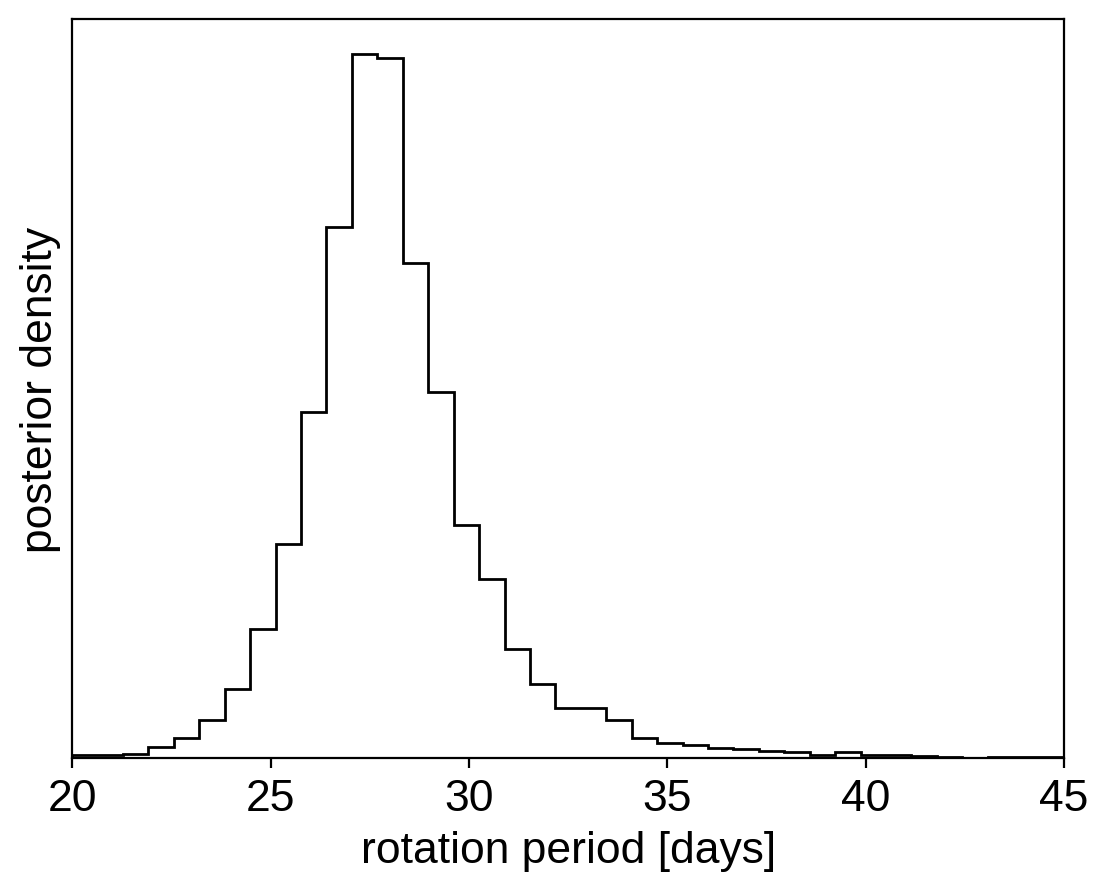

In [9]:
period_samples = trace["period"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [10]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [11]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.0},
   month = apr,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
